<a href="https://colab.research.google.com/github/lahirunie-dulsara/EN3150-Assignment-3-CNN/blob/Aazir/realwaste_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import shutil
from sklearn.model_selection import train_test_split
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import zipfile, os, re, shutil
from PIL import Image

zip_path = "/content/drive/MyDrive/Pattern Recognition/realwaste.zip"

extract_path = "/content"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped to:", extract_path)


Unzipped to: /content


In [5]:
base_dir = "/content/realwaste-main/RealWaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Vegetation: 436 images
Plastic: 921 images
Metal: 790 images
Paper: 500 images
Cardboard: 461 images
Textile Trash: 318 images
Miscellaneous Trash: 495 images
Glass: 420 images
Food Organics: 411 images


----------Dataset Summary----------
Total images: 4752
Number of classes: 9
Images per class:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Unique image sizes:
  (524, 524): 4752 images

Loaded in 0.36 seconds!


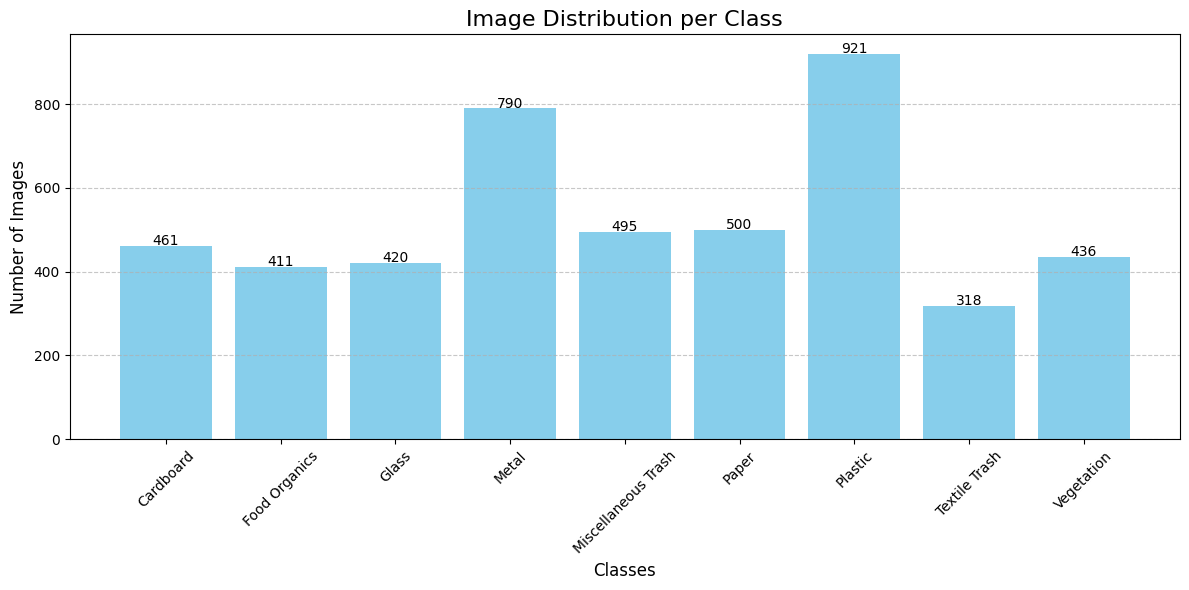

In [6]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np
import torch
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Configuration
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
RANDOM_SEED = 42
DATA_DIR = "/content/realwaste-main/RealWaste"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

class RealWasteDataset(Dataset):
    def __init__(self, root_dir=None, data=[], labels=[], size=None, transforms=[], transform=None, print_info=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.transform = transform
        self.data = data
        self.labels = labels
        self.image_sizes = {} if size is None else {size}

        # Class mapping
        self.classes = {
            0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal',
            4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'
        }

        start = time.time()

        if root_dir is not None:
            for label, label_name in self.classes.items():
                class_dir = os.path.join(self.root_dir, label_name)
                if not os.path.exists(class_dir):
                    continue
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)

                    try:
                        with Image.open(img_path) as img:
                            img.verify()
                            img_size = img.size
                            self.image_sizes[img_size] = self.image_sizes.get(img_size, 0) + 1
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

                    self.data.append(img_path)
                    self.labels.append(label)

        end = time.time()

        if print_info:
            self.print_info(round(end - start, 2))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms[idx](image)
        elif self.transform:
            image = self.transform(image)

        return image, label

    def to_dataframe(self):
        return pd.DataFrame({
            'image_path': self.data,
            'label': self.labels,
            'transformation': [self.transform for _ in range(len(self.labels))]
        })

    def print_info(self, elapsed):
        print("----------Dataset Summary----------")
        print(f"Total images: {len(self.data)}")
        print(f"Number of classes: {len(self.classes)}")
        print("Images per class:")

        class_counts = {label_name: 0 for label_name in self.classes.values()}
        for label in self.labels:
            class_name = self.classes[label]
            class_counts[class_name] += 1

        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} images")

        print("\nUnique image sizes:")
        for size, count in self.image_sizes.items():
            print(f"  {size}: {count} images")
        print(f"\nLoaded in {elapsed} seconds!")

transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
])

full_dataset = RealWasteDataset(DATA_DIR, transform=transform)

# Visualize class distribution
def plot_class_distribution_from_dataframe(dataframe, label_to_class, title="Image Distribution per Class", color='skyblue'):
    label_counts = Counter(dataframe['label'])
    sorted_labels = sorted(label_counts.items())

    plt.figure(figsize=(12, 6))
    bars = plt.bar([label_to_class[label] for label, _ in sorted_labels], [count for _, count in sorted_labels], color=color)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, str(yval), ha='center', fontsize=10, color='black')

    plt.title(title, fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_class_distribution_from_dataframe(full_dataset.to_dataframe(), full_dataset.classes)


Augmenting Images: 100%|██████████| 3326/3326 [00:00<00:00, 25013.14it/s]


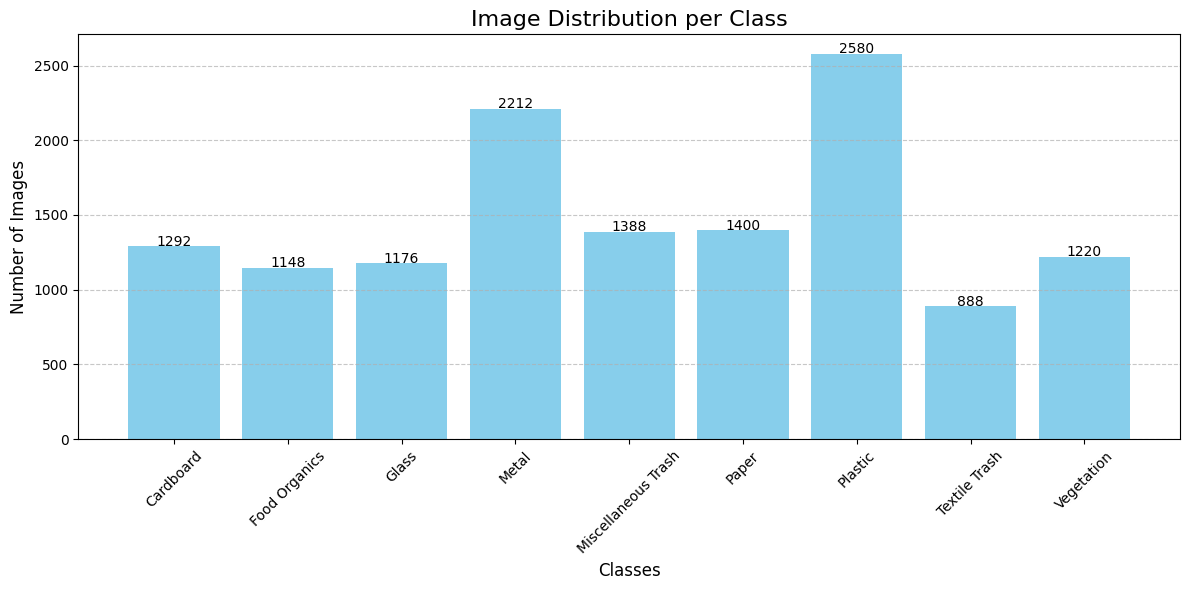

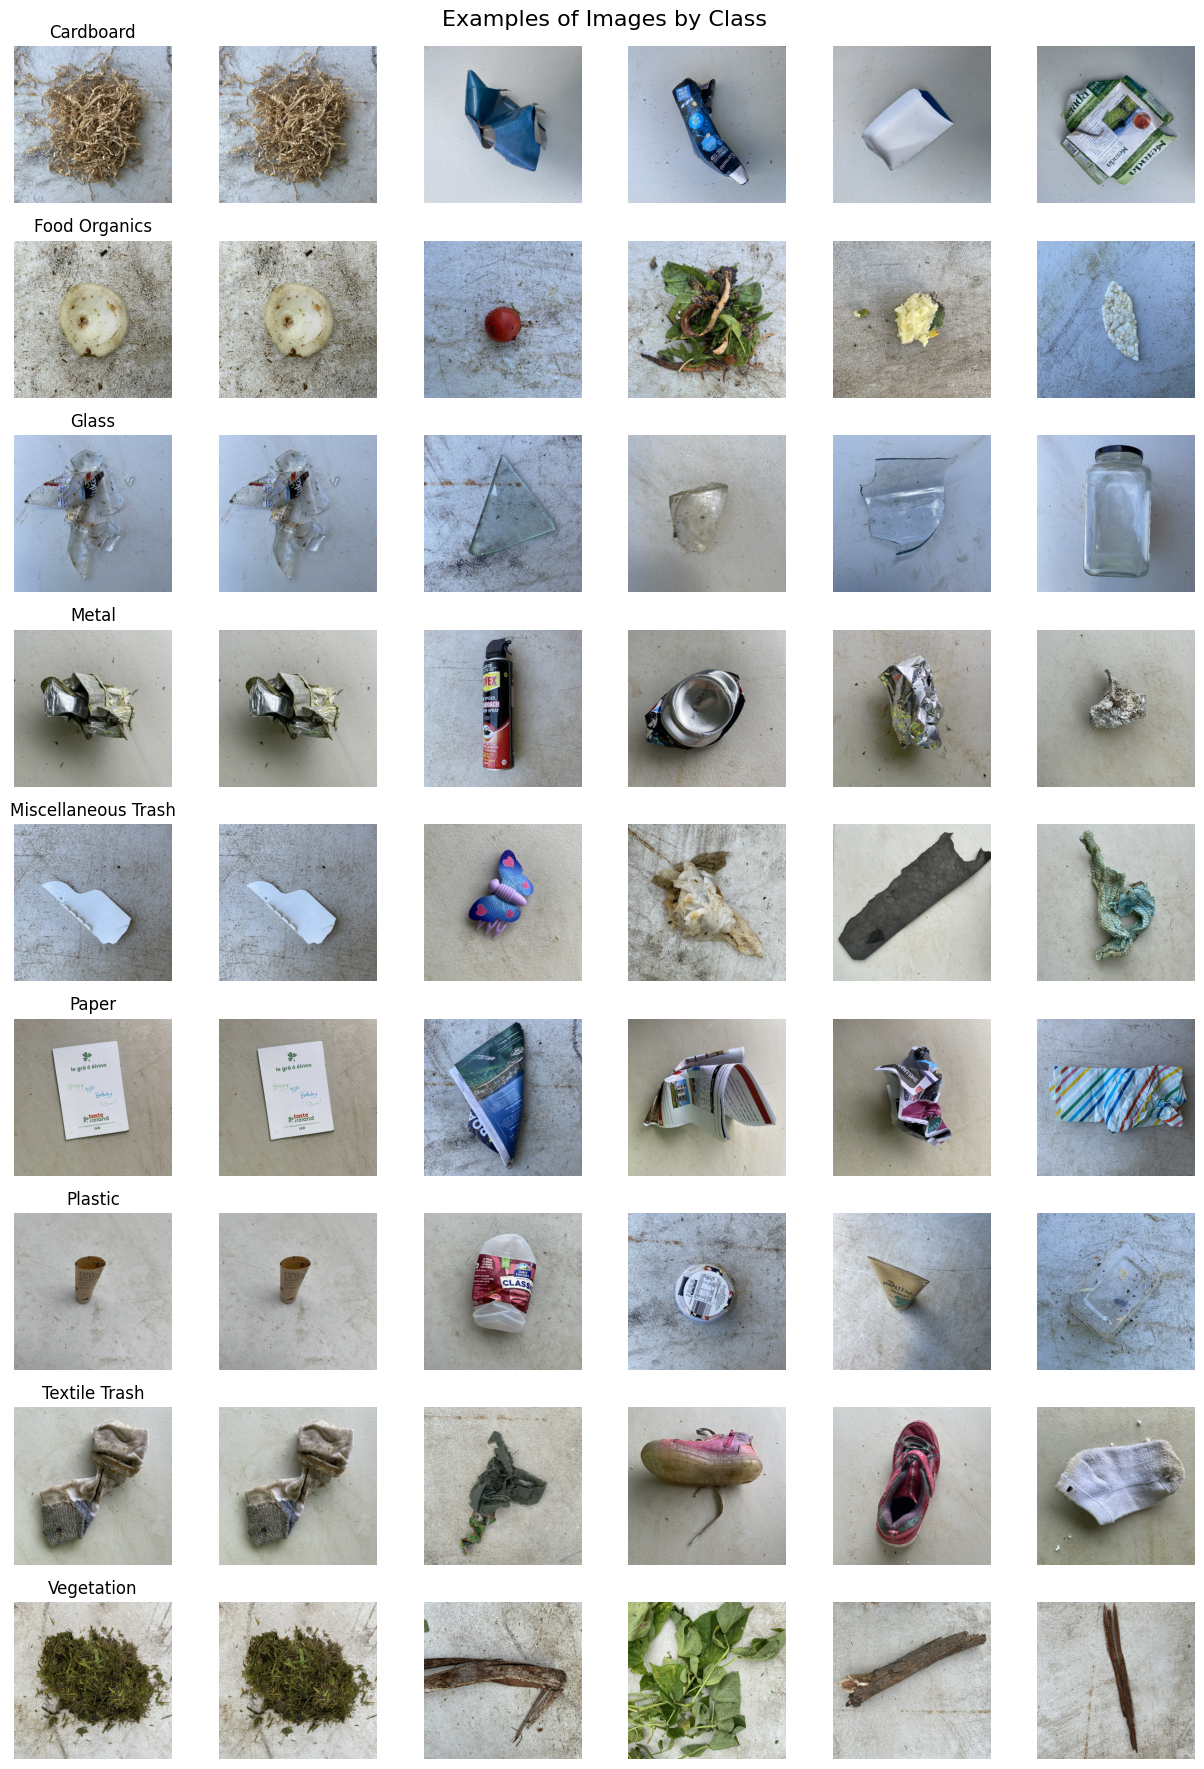

In [7]:
# Stratified Split
def train_val_test_split(full_dataframe, test_size, val_size, random_seed=RANDOM_SEED):
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    for train_val_idx, test_idx in stratified_split.split(full_dataframe, full_dataframe['label']):
        train_val_df = full_dataframe.iloc[train_val_idx]
        test_df = full_dataframe.iloc[test_idx]

    val_adjusted_size = val_size / (1 - test_size)
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_adjusted_size, random_state=random_seed)
    for train_idx, val_idx in stratified_split.split(train_val_df, train_val_df['label']):
        train_df = train_val_df.iloc[train_idx]
        val_df = train_val_df.iloc[val_idx]

    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test_split(full_dataset.to_dataframe(), test_size=TEST_SPLIT, val_size=VAL_SPLIT)

# Visualizing Augmented Dataset
def augment_train(train_df, duplication_factor):
    transform_augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomResizedCrop(size=IMG_SIZE[0], scale=(0.6, 0.9)),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])

    augmented_rows = []
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting Images"):
        img_path, label = row['image_path'], row['label']
        for _ in range(duplication_factor):
            augmented_rows.append({
                "image_path": img_path,
                "label": label,
                "transformation": transform_augment
            })

    augmented_df = pd.DataFrame(augmented_rows)
    combined_df = pd.concat([train_df, augmented_df], ignore_index=True)
    return combined_df

train_df_augmented = augment_train(train_df, duplication_factor=3)

plot_class_distribution_from_dataframe(train_df_augmented, full_dataset.classes)

# Visualizing Training Images by Class
def plot_training_images_by_class(train_df_augmented, class_names, ncols=5, title="Examples of Images by Class"):
    sampled_images = defaultdict(list)
    for label in train_df_augmented['label'].unique():
        class_df = train_df_augmented[train_df_augmented['label'] == label]
        sampled_df = class_df.sample(min(len(class_df), ncols), random_state=RANDOM_SEED)
        for _, row in sampled_df.iterrows():
            sampled_images[label].append(row)

    classes = sorted(sampled_images.keys())
    nrows = len(classes)
    fig, axs = plt.subplots(nrows, ncols + 1, figsize=(ncols * 2.5, nrows * 2))
    fig.suptitle(title, fontsize=16)

    for i, label in enumerate(classes):
        axs[i, 0].imshow(Image.open(sampled_images[label][0]['image_path']))
        axs[i, 0].set_title(class_names[label], fontsize=12)
        axs[i, 0].axis('off')

        for j in range(ncols):
            img_path = sampled_images[label][j]['image_path']
            axs[i, j+1].imshow(Image.open(img_path))
            axs[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_images_by_class(train_df_augmented, full_dataset.classes)


In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RealWasteDataset(Dataset):
    def __init__(self, data, labels, transforms=None, print_info=True):
        self.data = data  # List of image paths
        self.labels = labels  # List of labels (numeric or one-hot encoded)
        self.transforms = transforms  # List of transformations
        self.print_info = print_info  # Whether to print dataset info

        # Print dataset info if specified
        if self.print_info:
            print(f"Dataset contains {len(data)} images.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.data[idx]
        label = self.labels[idx]

        img = Image.open(img_path)

        # Apply transformations (if any)
        if self.transforms:
            img = self.transforms[idx](img)

        return img, label


In [9]:
import pandas as pd
from torch.utils.data import DataLoader

# Constants
BATCH_SIZE = 32  # Example batch size

# Assuming you have the augmented DataFrames loaded as train_df_augmented, val_df, test_df
# # Replace this with your actual DataFrame loading method

# # Example data for the DataLoader
# train_df_augmented = pd.read_csv('/path/to/your/train_df_augmented.csv')
# val_df = pd.read_csv('/path/to/your/val_df.csv')
# test_df = pd.read_csv('/path/to/your/test_df.csv')

# Create Datasets
train_dataset = RealWasteDataset(
    data=train_df_augmented['image_path'].to_list(),
    labels=train_df_augmented['label'].to_list(),
    transforms=train_df_augmented['transformation'].to_list(),
    print_info=False
)

val_dataset = RealWasteDataset(
    data=val_df['image_path'].to_list(),
    labels=val_df['label'].to_list(),
    transforms=val_df['transformation'].to_list(),
    print_info=False
)

test_dataset = RealWasteDataset(
    data=test_df['image_path'].to_list(),
    labels=test_df['label'].to_list(),
    transforms=test_df['transformation'].to_list(),
    print_info=False
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print dataset information
print("Train", end='\n\t')
print(f"Batches: {len(train_loader)}", end='\n\t')
print(f"Images: {len(train_loader.dataset)}")
print("Validation", end='\n\t')
print(f"Batches: {len(val_loader)}", end='\n\t')
print(f"Images: {len(val_loader.dataset)}")
print("Test", end='\n\t')
print(f"Batches: {len(test_loader)}", end='\n\t')
print(f"Images: {len(test_loader.dataset)}")


Train
	Batches: 416
	Images: 13304
Validation
	Batches: 23
	Images: 713
Test
	Batches: 23
	Images: 713


In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create the class weights
class_counts = np.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
num_classes = len(full_dataset.classes)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the training results dataframe
def update_training_results_csv(model_name, optimizer, lr, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies):

    csv_path = 'training_results.csv'

    # Controlla se il file CSV esiste
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Se non esiste, crea un DataFrame vuoto con le colonne necessarie
        df = pd.DataFrame(columns=["model_name",
                                   "epoch",
                                   "optimizer",
                                   "learning_rate",
                                   "weight_decay",
                                   "train_loss",
                                   "val_loss",
                                   "train_accuracy",
                                   "val_accuracy"
                                  ]
                         )

    # Rimuovi eventuali vecchie entry per il modello
    df = df[df['model_name'] != model_name]

    # Crea un nuovo DataFrame con i risultati attuali
    new_entries = {
        "model_name": [model_name] * len(train_losses),
        "epoch": list(range(1, len(train_losses) + 1)),
        "optimizer": [optimizer] * len(train_losses),
        "learning_rate": [lr] * len(train_losses),
        "weight_decay": [weight_decay] * len(train_losses),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }

    new_df = pd.DataFrame(new_entries)

    # Concatenare i nuovi dati con quelli esistenti
    df = pd.concat([df, new_df], ignore_index=True)

    # Salva il DataFrame aggiornato nel file CSV
    df.to_csv(csv_path, index=False)

    print(f"Dati di training per '{model_name}' aggiornati in '{csv_path}'")

# Function to train the model with a progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for training
        with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backpropagation
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar
                tepoch.set_postfix(loss=running_loss / len(tepoch), accuracy=100 * correct_train / total_train)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Progress bar for validation
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as vepoch:
            with torch.no_grad():
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                    # Update the progress bar
                    vepoch.set_postfix(loss=val_loss / len(vepoch), accuracy=100 * correct_val / total_val)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Useful plot function
def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Function to plot the graph of losses and accuracies during training and validation.

    Args:
        train_losses (list): List containing loss values during training.
        val_losses (list): List containing loss values during validation.
        train_accuracies (list): List containing accuracies during training.
        val_accuracies (list): List containing accuracies during validation.
    """
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [11]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()

        # Blocco convoluzionale base
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filtri
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filtri
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filtri
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filtri
        self.conv_block5 = self._create_conv_block(512, 512)  # 512 filtri aggiuntivi

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Strati completamente connessi
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        """Crea un blocco convoluzionale standard."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Strati densi
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
# Istanza del modello
model = CNNModel(num_classes=9)

model_name = "Custom CNN"

# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Conversione dei pesi al dispositivo
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Personalizza i pesi
criterion = nn.CrossEntropyLoss(weight=weights)

# Modello sul dispositivo
model = model.to(device)

# Ottimizzatore
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Scheduler del learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Numero di epoche
num_epochs = 15

# Training del modello
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot delle metriche di training e validazione
plot_training_validation_metrics(
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)


Using device: cuda


Validation Epoch 1/15: 100%|██████████| 23/23 [00:07<00:00,  3.03batch/s, accuracy=58.2, loss=1.07]


Epoch 1/15, Train Loss: 1.4238, Train Accuracy: 50.20%, Val Loss: 1.0741, Val Accuracy: 58.20%


Validation Epoch 2/15: 100%|██████████| 23/23 [00:06<00:00,  3.33batch/s, accuracy=65.6, loss=0.909]


Epoch 2/15, Train Loss: 1.0112, Train Accuracy: 64.22%, Val Loss: 0.9088, Val Accuracy: 65.64%


Validation Epoch 3/15: 100%|██████████| 23/23 [00:06<00:00,  3.33batch/s, accuracy=70.3, loss=0.807]


Epoch 3/15, Train Loss: 0.8531, Train Accuracy: 70.12%, Val Loss: 0.8069, Val Accuracy: 70.27%


Validation Epoch 4/15: 100%|██████████| 23/23 [00:07<00:00,  3.10batch/s, accuracy=71.4, loss=0.796]


Epoch 4/15, Train Loss: 0.7416, Train Accuracy: 73.71%, Val Loss: 0.7962, Val Accuracy: 71.39%


Validation Epoch 5/15: 100%|██████████| 23/23 [00:07<00:00,  3.02batch/s, accuracy=72.7, loss=0.738]


Epoch 5/15, Train Loss: 0.6526, Train Accuracy: 76.62%, Val Loss: 0.7384, Val Accuracy: 72.65%


Validation Epoch 6/15: 100%|██████████| 23/23 [00:07<00:00,  3.25batch/s, accuracy=74.6, loss=0.643]


Epoch 6/15, Train Loss: 0.5986, Train Accuracy: 78.23%, Val Loss: 0.6434, Val Accuracy: 74.61%


Validation Epoch 7/15: 100%|██████████| 23/23 [00:06<00:00,  3.40batch/s, accuracy=75.5, loss=0.658]


Epoch 7/15, Train Loss: 0.5435, Train Accuracy: 80.90%, Val Loss: 0.6580, Val Accuracy: 75.46%


Validation Epoch 8/15: 100%|██████████| 23/23 [00:07<00:00,  3.00batch/s, accuracy=78.7, loss=0.581]


Epoch 8/15, Train Loss: 0.4984, Train Accuracy: 82.20%, Val Loss: 0.5808, Val Accuracy: 78.68%


Validation Epoch 9/15: 100%|██████████| 23/23 [00:07<00:00,  3.06batch/s, accuracy=79, loss=0.558]


Epoch 9/15, Train Loss: 0.4499, Train Accuracy: 84.05%, Val Loss: 0.5581, Val Accuracy: 78.96%


Validation Epoch 10/15: 100%|██████████| 23/23 [00:06<00:00,  3.32batch/s, accuracy=78.5, loss=0.547]


Epoch 10/15, Train Loss: 0.4275, Train Accuracy: 84.61%, Val Loss: 0.5466, Val Accuracy: 78.54%


Validation Epoch 11/15: 100%|██████████| 23/23 [00:06<00:00,  3.43batch/s, accuracy=79.7, loss=0.63]


Epoch 11/15, Train Loss: 0.3841, Train Accuracy: 86.55%, Val Loss: 0.6296, Val Accuracy: 79.66%


Validation Epoch 12/15: 100%|██████████| 23/23 [00:07<00:00,  3.09batch/s, accuracy=78, loss=0.541]


Epoch 12/15, Train Loss: 0.3693, Train Accuracy: 87.02%, Val Loss: 0.5414, Val Accuracy: 77.98%


Validation Epoch 13/15: 100%|██████████| 23/23 [00:07<00:00,  3.08batch/s, accuracy=81.3, loss=0.516]


Epoch 13/15, Train Loss: 0.3403, Train Accuracy: 87.72%, Val Loss: 0.5161, Val Accuracy: 81.35%


Validation Epoch 14/15: 100%|██████████| 23/23 [00:06<00:00,  3.37batch/s, accuracy=81.1, loss=0.501]


Epoch 14/15, Train Loss: 0.3295, Train Accuracy: 88.06%, Val Loss: 0.5007, Val Accuracy: 81.07%


Validation Epoch 15/15: 100%|██████████| 23/23 [00:07<00:00,  3.08batch/s, accuracy=79.9, loss=0.591]

Epoch 15/15, Train Loss: 0.3117, Train Accuracy: 88.94%, Val Loss: 0.5908, Val Accuracy: 79.94%


RuntimeError: Parent directory /kaggle/working does not exist.

In [13]:
# Save the model
model_save_path = f"/content/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/trained_Custom CNN_model.pth


Evaluating custom CNN model: trained_Custom CNN_model.pth


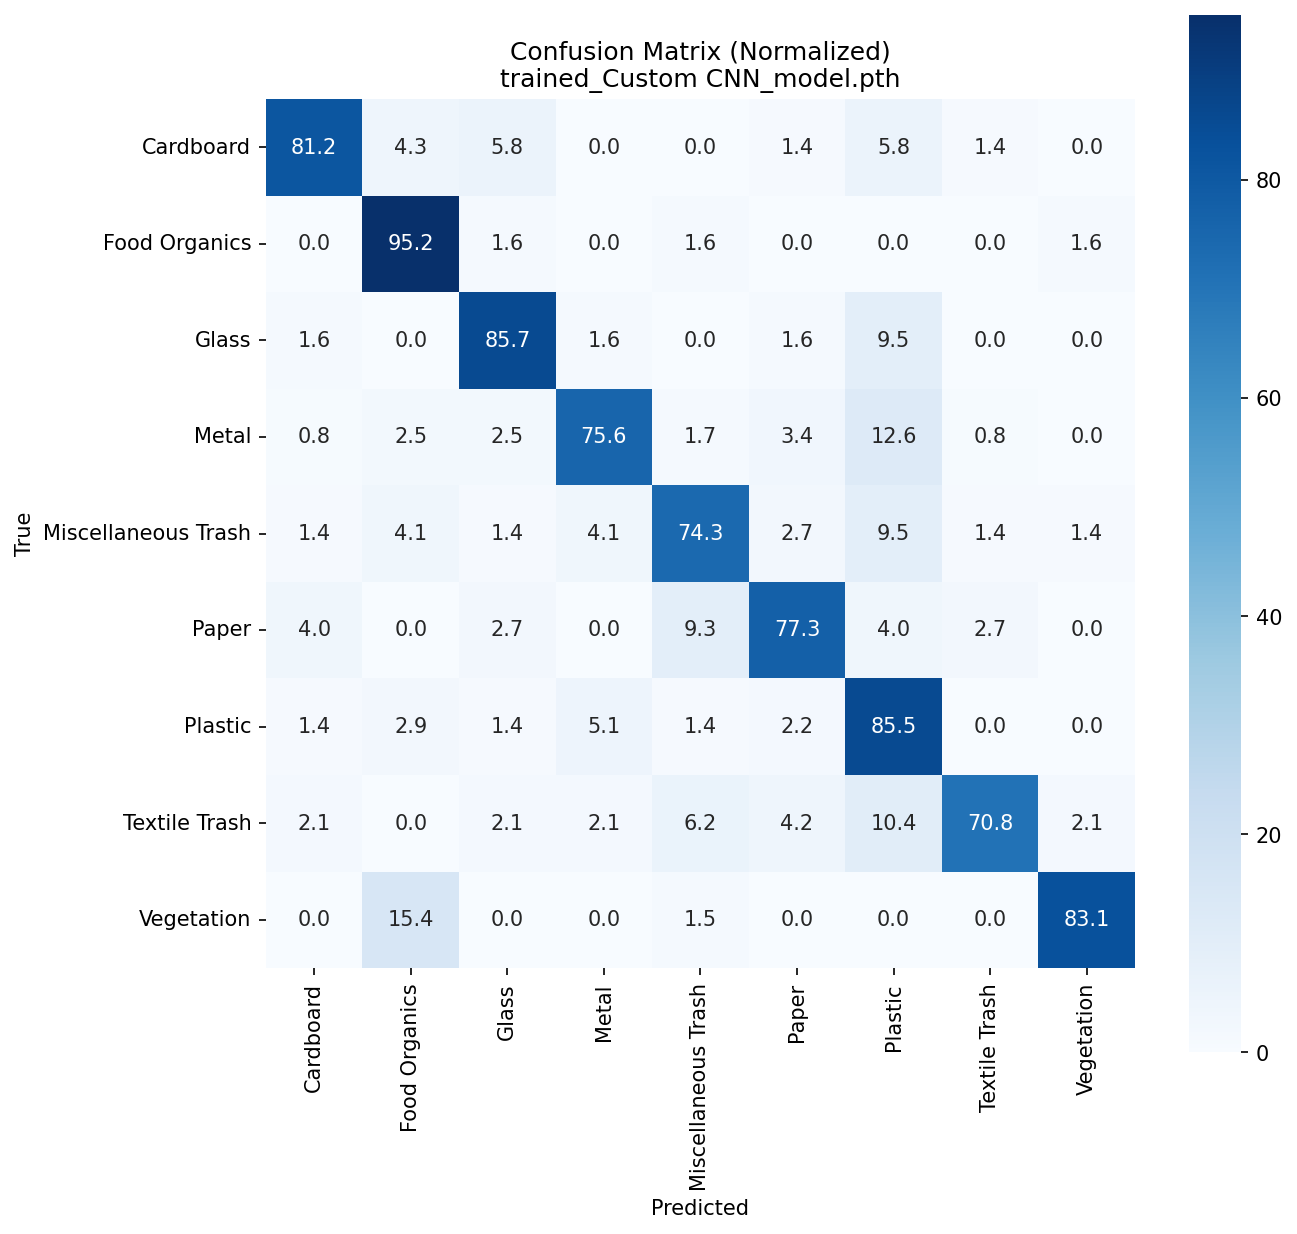

Classification Report for trained_Custom CNN_model.pth:

                     precision    recall  f1-score   support

          Cardboard       0.86      0.81      0.84        69
      Food Organics       0.72      0.95      0.82        62
              Glass       0.79      0.86      0.82        63
              Metal       0.88      0.76      0.81       119
Miscellaneous Trash       0.77      0.74      0.76        74
              Paper       0.82      0.77      0.79        75
            Plastic       0.75      0.86      0.80       138
      Textile Trash       0.87      0.71      0.78        48
         Vegetation       0.95      0.83      0.89        65

           accuracy                           0.81       713
          macro avg       0.82      0.81      0.81       713
       weighted avg       0.82      0.81      0.81       713





/tmp/ipython-input-2287708076.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_array, x=class_metrics[metric], ax=ax, palette="viridis")
/tmp/ipython-input-2287708076.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_array, x=class_metrics[metric], ax=ax, palette="viridis")
/tmp/ipython-input-2287708076.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_array, x=class_metrics[metric], ax=ax, palette="viridis")


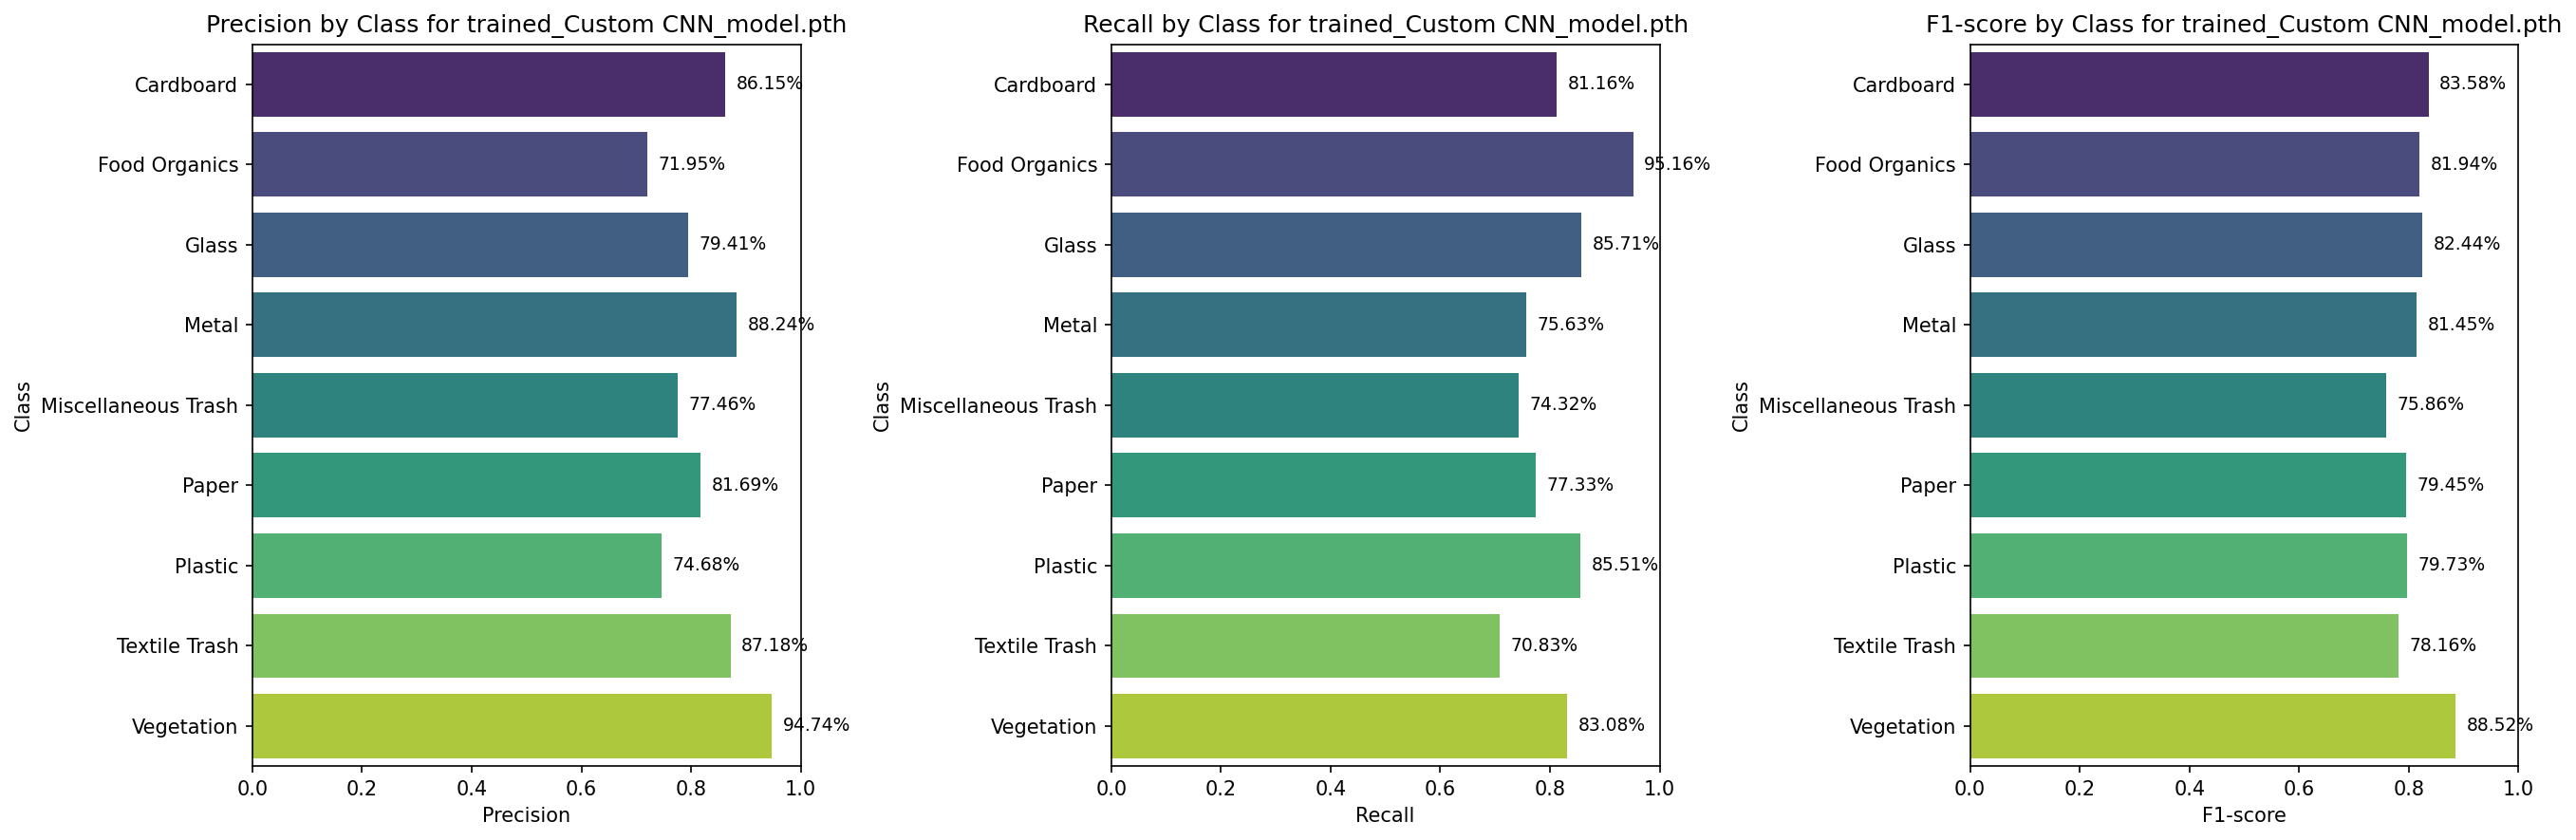

/tmp/ipython-input-2287708076.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_values, y=model_names, palette="viridis")


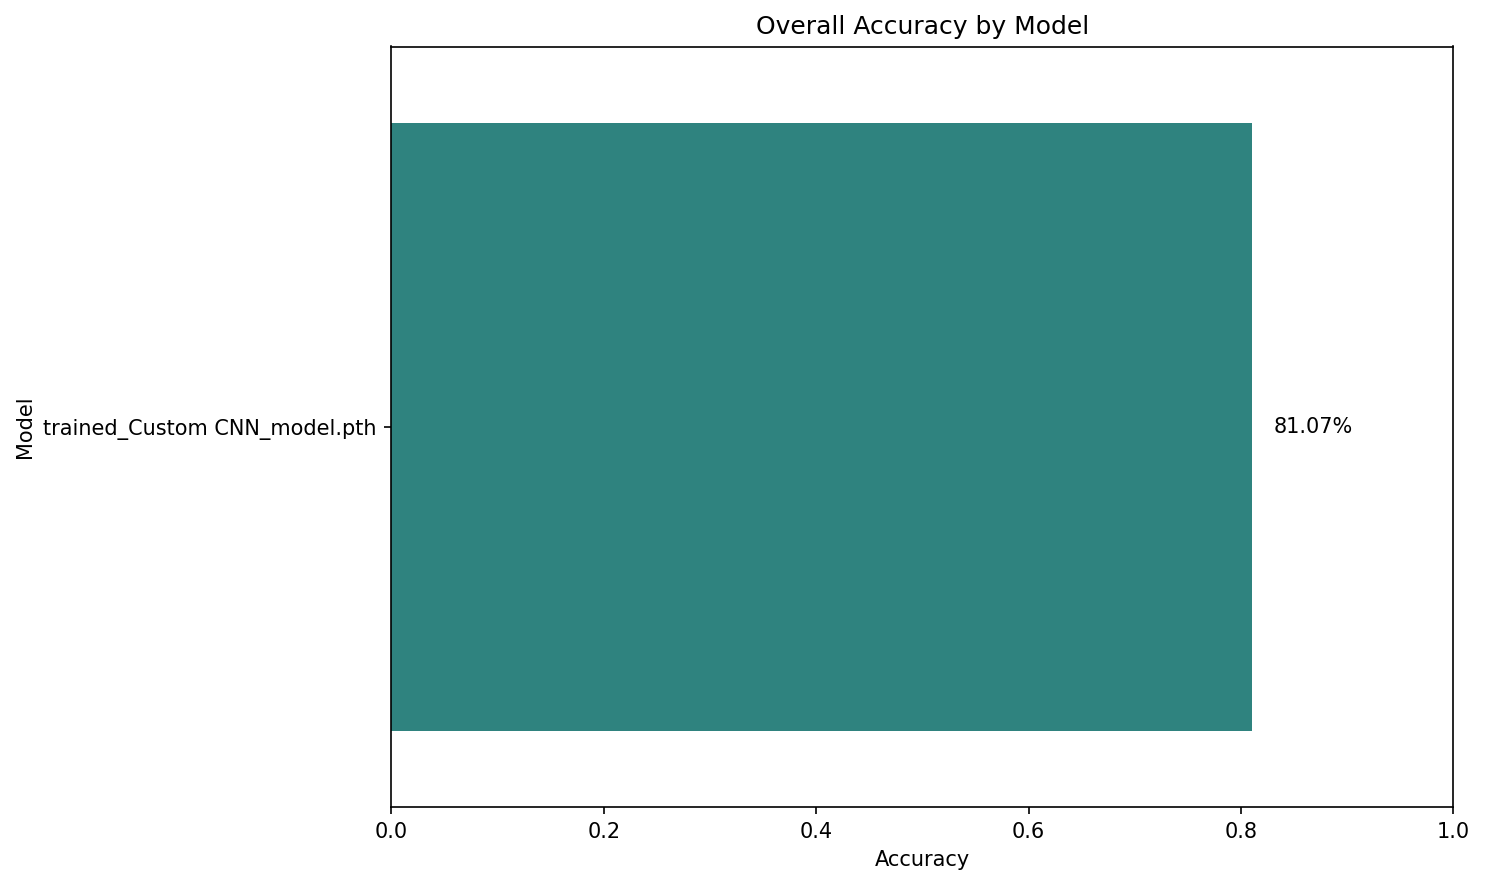

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set the path to the directory containing the models
models_path = "/content/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of class names
class_names = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()

        # Blocco convoluzionale base
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filtri
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filtri
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filtri
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filtri
        self.conv_block5 = self._create_conv_block(512, 512)  # 512 filtri aggiuntivi

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Strati completamente connessi
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        """Crea un blocco convoluzionale standard."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Strati densi
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def load_custom_cnn_model(model_path, num_classes):
    """Load the custom CNN model."""
    model = CNNModel(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def evaluate_custom_cnn_models(models_path, test_loader, num_classes):
    """Evaluate the custom CNN model and store predictions and labels."""
    model_files = [f for f in os.listdir(models_path) if f.endswith("model.pth")]
    results = {}
    for model_file in model_files:
        model_path = os.path.join(models_path, model_file)
        print(f"Evaluating custom CNN model: {model_file}")
        model = load_custom_cnn_model(model_path, num_classes)
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        results[model_file] = {
            "preds": np.concatenate(all_preds),
            "labels": np.concatenate(all_labels)
        }
    return results

def plot_confusion_matrices(results):
    """Plot normalized confusion matrices (percentages) for all models with a maximum of three matrices per row."""
    num_models = len(results)
    cols = 3  # Max 3 confusion matrices per row
    rows = -(-num_models // cols)  # Round up division to calculate number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows), dpi=150)
    axes = axes.flatten()  # Flatten axes array for easier indexing

    for i, (model_file, data) in enumerate(results.items()):
        # Compute confusion matrix and normalize it by row
        cm = confusion_matrix(data["labels"], data["preds"], normalize='true')
        cm_percentage = cm * 100  # Convert to percentage

        # Plot confusion matrix with percentages rounded to 1 decimal place
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f"Confusion Matrix (Normalized)\n{model_file}", fontsize=12)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
        axes[i].set_aspect('equal')  # Maintain aspect ratio

    # Remove unused axes if number of models is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("confusion_matrices.png", dpi=300, bbox_inches="tight", format="png")
    plt.show()

def plot_classification_reports(results):
    """Plot classification reports for all models."""
    for model_file, data in results.items():
        report = classification_report(data["labels"], data["preds"], target_names=class_names)
        print(f"Classification Report for {model_file}:\n")
        print(report)
        print("\n" + "=" * 80 + "\n")

def plot_classification_metrics(results):
    """Plot precision, recall, and F1-score for all models with percentages on bars."""
    metrics = ['precision', 'recall', 'f1-score']
    for model_file, data in results.items():
        # Generate classification report as a dictionary
        report = classification_report(
            data["labels"], data["preds"], target_names=class_names, output_dict=True
        )

        # Extract metrics for each class (excluding 'accuracy' and 'macro avg')
        class_metrics = {metric: [] for metric in metrics}
        for class_name in class_names:
            for metric in metrics:
                class_metrics[metric].append(report[class_name][metric])

        # Convert class names to a numpy array to avoid Seaborn warnings
        class_array = np.array(class_names)

        # Plot metrics for the current model
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
        for ax, metric in zip(axes, metrics):
            # Create barplot
            sns.barplot(y=class_array, x=class_metrics[metric], ax=ax, palette="viridis")
            ax.set_title(f"{metric.capitalize()} by Class for {model_file}")
            ax.set_xlabel(metric.capitalize())
            ax.set_ylabel("Class")
            ax.set_xlim(0, 1)  # Scores are between 0 and 1

            # Add percentage labels inside bars
            for i, value in enumerate(class_metrics[metric]):
                ax.text(
                    value + 0.02, i, f"{value:.2%}", va="center", ha="left", fontsize=9
                )

        plt.tight_layout()
        # Save each model's figure with a different name
        plt.savefig(f"classification_metrics_{model_file}.png", dpi=300, bbox_inches="tight", format="png")
        plt.show()

def plot_model_accuracies(results):
    """Plot overall accuracy for all models."""
    accuracies = {}
    for model_file, data in results.items():
        # Generate classification report as a dictionary
        report = classification_report(
            data["labels"], data["preds"], target_names=class_names, output_dict=True
        )
        # Extract overall accuracy
        accuracies[model_file] = report['accuracy']

    # Convert model names to a numpy array to avoid warnings
    model_names = np.array(list(accuracies.keys()))
    accuracy_values = list(accuracies.values())

    plt.figure(figsize=(10, 6), dpi=150)
    sns.barplot(x=accuracy_values, y=model_names, palette="viridis")
    plt.title("Overall Accuracy by Model")
    plt.xlabel("Accuracy")
    plt.ylabel("Model")
    plt.xlim(0, 1)  # Accuracy is between 0 and 1

    # Add percentage labels inside bars
    for i, value in enumerate(accuracy_values):
        plt.text(
            value + 0.02, i, f"{value:.2%}", va="center", ha="left", fontsize=10
        )

    plt.tight_layout()
    plt.savefig("model_accuracies.png", dpi=300, bbox_inches="tight", format="png")
    plt.show()

# Evaluation and plotting for custom CNN
num_classes = len(class_names)
results = evaluate_custom_cnn_models(models_path, test_loader, num_classes)
plot_confusion_matrices(results)
plot_classification_reports(results)
plot_classification_metrics(results)
plot_model_accuracies(results)


In [ ]:
import torch
import os
import numpy as np

class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()

        # Blocco convoluzionale base
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filtri
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filtri
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filtri
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filtri
        self.conv_block5 = self._create_conv_block(512, 512)  # 512 filtri aggiuntivi

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Strati completamente connessi
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        """Crea un blocco convoluzionale standard."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Strati densi
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def load_model(model_path, device):
    """
    Load the model from the specified path and ensure it's ready for evaluation.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model path '{model_path}' does not exist.")

    # Check if the model file ends with '.pth'
    model_files = [f for f in os.listdir(model_path) if f.endswith('.pth')]
    if not model_files:
        raise FileNotFoundError("No model files ending with '.pth' found in the directory.")

    model_file_path = os.path.join(model_path, model_files[0])
    print(f"Loading model from {model_file_path}")

    # Load the state dict
    model = torch.load(model_file_path, map_location=device)
    model.eval()
    return model

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model and collect predictions and labels.
    """
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            # Ensure that images and labels are not empty
            if images.shape[0] == 0:
                print(f"Warning: Empty batch at index {batch_idx}")
                continue

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if not all_preds or not all_labels:
        print("Evaluation produced no predictions or labels.")
        return None

    print(f"Collected {len(all_preds)} predictions and {len(all_labels)} labels.")
    return np.array(all_preds), np.array(all_labels)

# Example Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define test data path and transformation
test_data_path = "/kaggle/input/last-test/test"  # Update with your actual test dataset path

# Define test transformations
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
try:
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    print(f"Loaded test dataset with {len(test_dataset)} images.")
except FileNotFoundError as e:
    print(f"Error loading test dataset: {e}")


Loaded test dataset with 43 images.


<ipython-input-52-df6dbf53f919>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


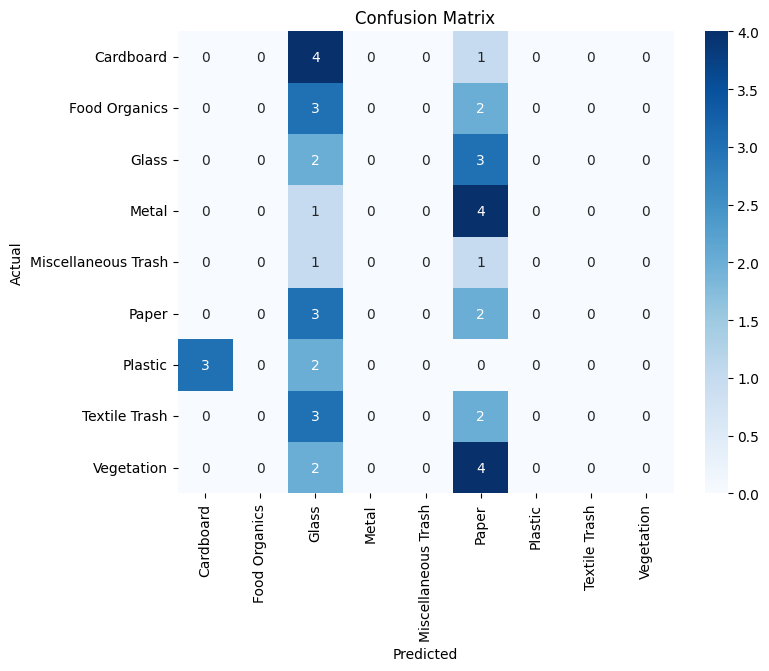

Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00         5
      Food Organics       0.00      0.00      0.00         5
              Glass       0.10      0.40      0.15         5
              Metal       0.00      0.00      0.00         5
Miscellaneous Trash       0.00      0.00      0.00         2
              Paper       0.11      0.40      0.17         5
            Plastic       0.00      0.00      0.00         5
      Textile Trash       0.00      0.00      0.00         5
         Vegetation       0.00      0.00      0.00         6

           accuracy                           0.09        43
          macro avg       0.02      0.09      0.04        43
       weighted avg       0.02      0.09      0.04        43



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        self.conv_block1 = self._create_conv_block(3, 64)
        self.conv_block2 = self._create_conv_block(64, 128)
        self.conv_block3 = self._create_conv_block(128, 256)
        self.conv_block4 = self._create_conv_block(256, 512)
        self.conv_block5 = self._create_conv_block(512, 512)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to load the model
def load_model(model_path, device):
    model = CNNModel()  # Instantiate the CNNModel class
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

# Evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Plot classification report
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

# Load and preprocess test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_path = "/kaggle/input/last-test/test"  # Update with your test dataset path
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/trained_Custom CNN_model.pth"  # Replace with your correct model path

try:
    model = load_model(model_path, device)
except FileNotFoundError:
    print(f"Model file not found at {model_path}. Please check the path and file name.")

# Evaluate and plot results if model loading succeeds
if 'model' in locals():
    predictions, labels = evaluate_model(model, test_loader, device)

    # Plot the confusion matrix and classification report
    class_names = test_dataset.classes
    plot_confusion_matrix(labels, predictions, class_names)
    plot_classification_report(labels, predictions, class_names)

In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ultralytics import YOLO

# Load a classification model (ResNet by default for classification tasks)
model = YOLO('yolov8n-cls.pt')

# Train the model on your dataset
model.train(data='/kaggle/working/SplitDataset', epochs=20, imgsz=224)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.31M/5.31M [00:00<00:00, 75.6MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/kaggle/working/SplitDataset, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/SplitDataset/train... 2993 images, 0 corrupt: 100%|██████████| 2993/2993 [00:01<00:00, 2143.36it/s]

train: New cache created: /kaggle/working/SplitDataset/train.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/SplitDataset/val... 1000 images, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 3394.16it/s]


val: New cache created: /kaggle/working/SplitDataset/val.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50     0.289G      2.208         16        224:   4%|▍         | 8/188 [00:00<00:15, 11.56it/s]

       1/50     0.289G      2.218         16        224:   7%|▋         | 14/188 [00:01<00:14, 12.06it/s]
100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.38it/s]

                   all      0.649      0.966



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.38it/s]

                   all      0.744      0.988



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]

                   all      0.799      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s]

                   all        0.8      0.989



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]

                   all      0.839      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s]

                   all      0.822      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]

                   all      0.837      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]

                   all      0.836      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]

                   all       0.85      0.994



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.262G     0.3632          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]

                   all      0.847      0.995



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.262G     0.2852          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s]

                   all      0.856      0.995



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.264G     0.2801          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.29it/s]

                   all       0.85      0.996



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.264G     0.2534          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.56it/s]

                   all      0.857      0.997



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.262G     0.2702          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.10it/s]

                   all      0.857      0.994



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.264G     0.2301          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s]

                   all      0.846      0.996



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.262G     0.2472          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]

                   all       0.85      0.997



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.264G     0.2031          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]

                   all      0.859      0.995



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.264G     0.2052          1        224: 100%|██████████| 188/188 [00:14<00:00, 12.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]

                   all      0.862      0.997



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.262G      0.183          1        224: 100%|██████████| 188/188 [00:14<00:00, 12.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]

                   all      0.868      0.997



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.262G     0.1746          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s]

                   all      0.865      0.994



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.264G     0.1779          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.31it/s]

                   all      0.868      0.996



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.264G     0.1706          1        224: 100%|██████████| 188/188 [00:14<00:00, 12.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]

                   all      0.847      0.996



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.264G     0.1457          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.97it/s]

                   all      0.859      0.997



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.264G     0.1608          1        224: 100%|██████████| 188/188 [00:14<00:00, 12.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s]

                   all      0.874      0.995



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.264G     0.1393          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s]

                   all      0.868      0.997



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.264G     0.1624          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.66it/s]

                   all      0.877      0.999



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.262G     0.1388          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]

                   all      0.879      0.995



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.262G     0.1349          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s]

                   all      0.875      0.994



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.262G     0.1285          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s]

                   all      0.881      0.996



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.264G     0.1082          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.22it/s]

                   all      0.873      0.998



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.264G     0.1256          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.23it/s]

                   all       0.88      0.998



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.264G     0.1016          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.32it/s]

                   all      0.879      0.997



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.262G      0.107          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]

                   all      0.888      0.997



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.262G     0.1076          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]

                   all      0.878      0.997



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.262G     0.1012          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]

                   all      0.882      0.998



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.264G     0.1054          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s]

                   all      0.882      0.996



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.262G    0.09741          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s]

                   all      0.887      0.995



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.262G    0.08722          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]

                   all      0.883      0.996



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.262G     0.1023          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]

                   all      0.883      0.997



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.264G    0.08452          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]

                   all      0.884      0.996



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.264G    0.08453          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s]

                   all       0.88      0.997



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.264G     0.1028          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]

                   all      0.888      0.997



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.264G    0.08407          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]

                   all      0.888      0.997



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.262G     0.0889          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]

                   all      0.887      0.997



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.262G    0.07337          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.44it/s]

                   all      0.886      0.997



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.262G    0.08402          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]

                   all      0.885      0.997



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.264G    0.07549          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.41it/s]

                   all      0.893      0.997



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.264G    0.08469          1        224: 100%|██████████| 188/188 [00:14<00:00, 13.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]

                   all       0.89      0.997



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.262G    0.08566          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  8.91it/s]

                   all      0.891      0.997



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.264G    0.07817          1        224: 100%|██████████| 188/188 [00:13<00:00, 13.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]

                   all      0.892      0.997



50 epochs completed in 0.245 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,446,409 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/SplitDataset/train... found 2993 images in 9 classes ✅ 
val: /kaggle/working/SplitDataset/val... found 1000 images in 9 classes ✅ 
test: /kaggle/working/SplitDataset/test... found 1001 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00, 10.48it/s]


                   all      0.893      0.997
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb5e22fa710>
curves: []
curves_results: []
fitness: 0.9449999928474426
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8930000066757202, 'metrics/accuracy_top5': 0.996999979019165, 'fitness': 0.9449999928474426}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.06679010391235352, 'inference': 0.25919198989868164, 'loss': 0.0004363059997558594, 'postprocess': 0.0006289482116699219}
task: 'classify'
top1: 0.8930000066757202
top5: 0.996999979019165

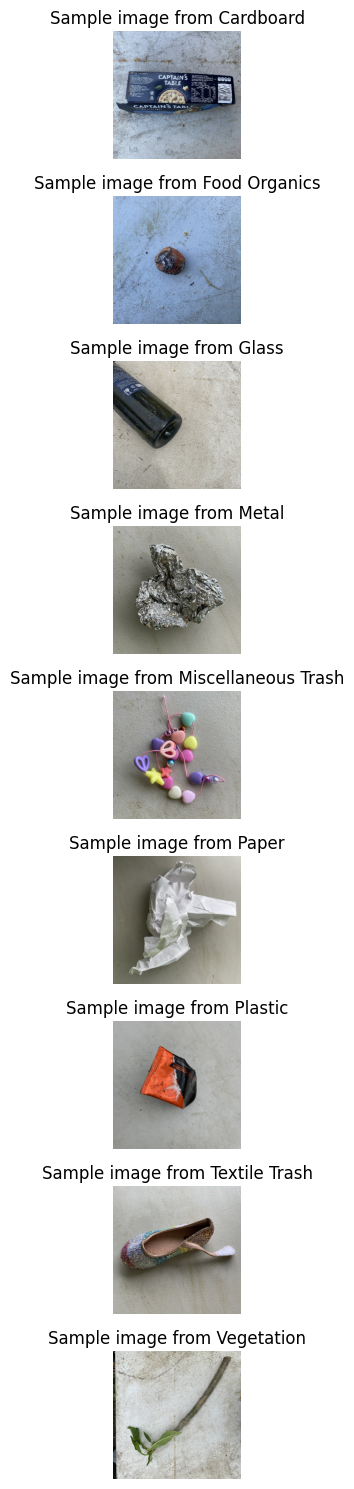

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Define the path to the test images
test_dir = Path('/kaggle/working/SplitDataset/test')

# List of classes
classes = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

# Set up the plot
fig, axes = plt.subplots(len(classes), 1, figsize=(5, 15))

# Loop through each class and display a sample image
for i, class_name in enumerate(classes):
    class_path = test_dir / class_name
    image_files = list(class_path.glob('*.jpg'))  # Adjust based on the image format if needed
    if image_files:
        image = cv2.imread(str(image_files[0]))  # Read the first image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
        axes[i].imshow(image)
        axes[i].set_title(f"Sample image from {class_name}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os

test_path = '/kaggle/working/SplitDataset/test'
print(os.listdir(test_path))  # List files in the test directory


['Cardboard', 'Glass', 'Textile Trash', 'Food Organics', 'Miscellaneous Trash', 'Plastic', 'Vegetation', 'Metal', 'Paper']


In [ ]:
print(model.names)  # This will show the class labels


{0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}


In [ ]:
# Pick one image from the test folder to test
test_image_path = '/kaggle/working/SplitDataset/test/Metal/00014099.jpg'  # Replace with actual image path
result = model.predict(test_image_path)
print(result)



image 1/1 /kaggle/working/SplitDataset/test/Metal/00014099.jpg: 224x224 Metal 0.95, Glass 0.04, Plastic 0.00, Textile Trash 0.00, Cardboard 0.00, 3.0ms
Speed: 12.1ms preprocess, 3.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}
obb: None
orig_img: array([[[ 66, 150, 239],
        [ 64, 148, 237],
        [ 62, 146, 235],
        ...,
        [  9,  91, 200],
        [ 20, 102, 211],
        [  3,  85, 194]],

       [[ 80, 164, 253],
        [ 76, 160, 249],
        [ 68, 152, 241],
        ...,
        [  2,  84, 193],
        [  4,  86, 195],
        [  0,  74, 183]],

       [[ 75, 159, 248],
        [ 79, 163, 252],
        [ 79, 163, 252],
        ...,
        [ 11,  93, 202],
        [ 12,  94, 203],
    

In [ ]:
import os

test_dir = '/kaggle/working/SplitDataset/test'
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if file_name.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff', 'webp')):
                print(f"Image found: {file_name} in {class_name}")
            else:
                print(f"Non-image file found: {file_name} in {class_name}")


Image found: Cardboard_122.jpg in Cardboard
Image found: Cardboard_311.jpg in Cardboard
Image found: Cardboard_92.jpg in Cardboard
Image found: Cardboard_338.jpg in Cardboard
Image found: Cardboard_221.jpg in Cardboard
Image found: Cardboard_93.jpg in Cardboard
Image found: Cardboard_453.jpg in Cardboard
Image found: Cardboard_439.jpg in Cardboard
Image found: Cardboard_381.jpg in Cardboard
Image found: Cardboard_398.jpg in Cardboard
Image found: Cardboard_202.jpg in Cardboard
Image found: Cardboard_66.jpg in Cardboard
Image found: Cardboard_361.jpg in Cardboard
Image found: Cardboard_85.jpg in Cardboard
Image found: Cardboard_30.jpg in Cardboard
Image found: Cardboard_165.jpg in Cardboard
Image found: Cardboard_75.jpg in Cardboard
Image found: Cardboard_52.jpg in Cardboard
Image found: Cardboard_139.jpg in Cardboard
Image found: Cardboard_27.jpg in Cardboard
Image found: Cardboard_272.jpg in Cardboard
Image found: Cardboard_201.jpg in Cardboard
Image found: cardboard_395.jpg in Cardbo

In [ ]:
test_dir = '/kaggle/working/SplitDataset/test'
images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg', '.bmp'))]
print(images)


[]


In [ ]:
card_dir = '/kaggle/working/SplitDataset/test/Cardboard'
print(os.listdir(card_dir))  # This should list images in the Cardboard folder


['Cardboard_122.jpg', 'Cardboard_311.jpg', 'Cardboard_92.jpg', 'Cardboard_338.jpg', 'Cardboard_221.jpg', 'Cardboard_93.jpg', 'Cardboard_453.jpg', 'Cardboard_439.jpg', 'Cardboard_381.jpg', 'Cardboard_398.jpg', 'Cardboard_202.jpg', 'Cardboard_66.jpg', 'Cardboard_361.jpg', 'Cardboard_85.jpg', 'Cardboard_30.jpg', 'Cardboard_165.jpg', 'Cardboard_75.jpg', 'Cardboard_52.jpg', 'Cardboard_139.jpg', 'Cardboard_27.jpg', 'Cardboard_272.jpg', 'Cardboard_201.jpg', 'cardboard_395.jpg', 'Cardboard_37.jpg', 'Cardboard_106.jpg', 'Cardboard_271.jpg', 'Cardboard_322.jpg', 'Cardboard_399.jpg', 'Cardboard_154.jpg', 'Cardboard_245.jpg', 'Cardboard_10.jpg', 'cardboard_177.jpg', 'Cardboard_402.jpg', 'Cardboard_267.jpg', 'Cardboard_290.jpg', 'Cardboard_344.jpg', 'Cardboard_207.jpg', 'Cardboard_357.jpg', 'Cardboard_225.jpg', 'Cardboard_306.jpg', 'Cardboard_229.jpg', 'Cardboard_157.jpg', 'Cardboard_176.jpg', 'Cardboard_424.jpg', 'Cardboard_418.jpg', 'Cardboard_430.jpg', 'Cardboard_138.jpg', 'Cardboard_152.jpg', '

In [ ]:
results = model.predict(source='/kaggle/working/SplitDataset/test/Cardboard', imgsz=640)



image 1/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_10.jpg: 224x224 Cardboard 1.00, Miscellaneous Trash 0.00, Paper 0.00, Vegetation 0.00, Glass 0.00, 3.3ms
image 2/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_100.jpg: 224x224 Cardboard 1.00, Food Organics 0.00, Paper 0.00, Miscellaneous Trash 0.00, Plastic 0.00, 2.9ms
image 3/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_103.jpg: 224x224 Food Organics 0.97, Cardboard 0.02, Plastic 0.01, Miscellaneous Trash 0.00, Vegetation 0.00, 2.9ms
image 4/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_106.jpg: 224x224 Cardboard 1.00, Paper 0.00, Miscellaneous Trash 0.00, Metal 0.00, Vegetation 0.00, 2.9ms
image 5/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_107.jpg: 224x224 Paper 0.90, Cardboard 0.10, Miscellaneous Trash 0.00, Plastic 0.00, Metal 0.00, 2.8ms
image 6/98 /kaggle/working/SplitDataset/test/Cardboard/Cardboard_116.jpg: 224x224 Cardboard 0.90, Miscellaneous Trash 0.05, Plastic 0

In [ ]:
import os
import cv2
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your YOLO model loaded
# model = your_trained_yolo_model

# Path to your test folder
test_folder = '/kaggle/working/SplitDataset/test'
print(f"Test folder path: {test_folder}")
print(f"Files in test folder: {os.listdir(test_folder)}")
for class_name in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_name)
    if os.path.isdir(class_path):
        print(f"Images in {class_name}: {len(os.listdir(class_path))} files")

# Initialize variables to hold true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test folder and make predictions
for image_name in os.listdir(test_folder):
    if image_name.endswith(".jpg") or image_name.endswith(".png"):
        # Load image
        image_path = os.path.join(test_folder, image_name)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Unable to load image {image_name}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocess the image for YOLO (resize, normalize, etc.)
        image_resized = cv2.resize(image_rgb, (224, 224))  # Assuming YOLO model takes 224x224 images
        image_input = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2) / 255.0

        # Predict using YOLO
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = model(image_input)

        # Assuming that the model outputs the predicted class probabilities
        predicted_class = torch.argmax(outputs, dim=1).item()  # Get the index of the class with max probability

        # Add the ground truth and prediction (assuming ground truth is part of the filename or you have it somewhere)
        true_class = get_true_class_from_image_name(image_name)  # Define a function to extract the true class
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

# Check if any predictions were made
if len(true_labels) == 0:
    print("No test images found or there was an issue loading the images.")
else:
    # Calculate accuracy
    correct_predictions = sum(np.array(true_labels) == np.array(predicted_labels))
    total_predictions = len(true_labels)
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using Seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Test folder path: /kaggle/working/SplitDataset/test
Files in test folder: ['Cardboard', 'Glass', 'Textile Trash', 'Food Organics', 'Miscellaneous Trash', 'Plastic', 'Vegetation', 'Metal', 'Paper']
Images in Cardboard: 98 files
Images in Glass: 90 files
Images in Textile Trash: 70 files
Images in Food Organics: 90 files
Images in Miscellaneous Trash: 102 files
Images in Plastic: 188 files
Images in Vegetation: 93 files
Images in Metal: 164 files
Images in Paper: 106 files
No test images found or there was an issue loading the images.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision.models import resnet18
from torchvision.transforms.functional import to_pil_image
from torch.cuda.amp import GradScaler, autocast
import numpy as np

# =============================================
# Configuration
# =============================================
DATA_PATH = "/kaggle/input/realwaste/realwaste-main/RealWaste"
CUSTOM_DATA_PATH = "/kaggle/input/custom-data/custom_test"  # Change this to your custom dataset path
CHECKPOINT_PATH = "./best_model.pth"
BATCH_SIZE = 64
ACCUMULATION_STEPS = 2
NUM_EPOCHS_SIMCLR = 50
NUM_EPOCHS_FINETUNE = 30

# =============================================
# Data Preparation & Augmentation
# =============================================
# SimCLR augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation/test transforms
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
main_dataset = datasets.ImageFolder(DATA_PATH, transform=val_transform)
custom_dataset = datasets.ImageFolder(CUSTOM_DATA_PATH, transform=val_transform)

# Combine datasets
combined_dataset = ConcatDataset([main_dataset, custom_dataset])
classes = main_dataset.classes

# Split combined dataset
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    combined_dataset, [train_size, val_size, test_size]
)

# =============================================
# SimCLR Dataset
# =============================================
class SimCLRDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = train_transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img)
        return (self.transform(img), self.transform(img)), label

    def __len__(self):
        return len(self.dataset)

simclr_train_dataset = SimCLRDataset(train_dataset)

# =============================================
# Model Architecture
# =============================================
class SimCLRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(*list(resnet18(weights=None).children())[:-1])
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.projection(torch.flatten(x, 1))

# =============================================
# Training Utilities
# =============================================
def nt_xent_loss(z1, z2, temperature=0.5):
    z = torch.cat([z1, z2], dim=0)
    sim = torch.mm(z, z.T) / temperature
    targets = torch.arange(z1.size(0), device=z.device).repeat(2)
    return F.cross_entropy(sim, targets)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return correct / len(loader.dataset)

# =============================================
# SIMCLR Pretraining
# =============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()

simclr_loader = DataLoader(
    simclr_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print("Starting SIMCLR Pretraining...")
for epoch in range(NUM_EPOCHS_SIMCLR):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, ((x1, x2), _) in enumerate(simclr_loader):
        x1, x2 = x1.to(device), x2.to(device)

        with autocast():
            z1 = model(x1)
            z2 = model(x2)
            loss = nt_xent_loss(z1, z2) / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i+1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUMULATION_STEPS

    avg_loss = total_loss / len(simclr_loader)
    print(f"SIMCLR Epoch [{epoch+1}/{NUM_EPOCHS_SIMCLR}] Loss: {avg_loss:.4f}")

# =============================================
# Fine-tuning
# =============================================
class FineTuneModel(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(512, len(classes))

    def forward(self, x):
        features = torch.flatten(self.encoder(x), 1)
        return self.classifier(features)

ft_model = FineTuneModel(model.backbone).to(device)

# Class weights for imbalance
class_counts = np.array([461, 411, 420, 790, 495, 500, 921, 318, 436])
class_weights = torch.tensor(1 / class_counts, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(ft_model.parameters(), lr=1e-4)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("\nStarting Fine-tuning...")
best_val_acc = 0
for epoch in range(NUM_EPOCHS_FINETUNE):
    ft_model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = ft_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    # Calculate metrics
    train_acc = train_correct / len(train_dataset)
    train_loss /= len(train_loader)
    val_acc = evaluate(ft_model, val_loader, device)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ft_model.state_dict(), CHECKPOINT_PATH)
        print(f"Saved new best model with val acc: {val_acc:.2%}")

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_FINETUNE}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2%}")
    print(f"Val Acc: {val_acc:.2%}\n")

# =============================================
# Final Evaluation
# =============================================
print("\nFinal Evaluation:")
ft_model.load_state_dict(torch.load(CHECKPOINT_PATH))
test_acc = evaluate(ft_model, test_loader, device)
print(f"Test Accuracy: {test_acc:.2%}")


Starting SIMCLR Pretraining...


<ipython-input-18-dd82ecb44bcf>:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-18-dd82ecb44bcf>:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


SIMCLR Epoch [1/50] Loss: 5.0744
SIMCLR Epoch [2/50] Loss: 2.9820
SIMCLR Epoch [3/50] Loss: 2.3654
SIMCLR Epoch [4/50] Loss: 2.0600
SIMCLR Epoch [5/50] Loss: 1.9673
SIMCLR Epoch [6/50] Loss: 1.8542
SIMCLR Epoch [7/50] Loss: 1.8135
SIMCLR Epoch [8/50] Loss: 1.6767
SIMCLR Epoch [9/50] Loss: 1.5989
SIMCLR Epoch [10/50] Loss: 1.6073
SIMCLR Epoch [11/50] Loss: 1.5442
SIMCLR Epoch [12/50] Loss: 1.5237
SIMCLR Epoch [13/50] Loss: 1.5155
SIMCLR Epoch [14/50] Loss: 1.5016
SIMCLR Epoch [15/50] Loss: 1.4675
SIMCLR Epoch [16/50] Loss: 1.3974
SIMCLR Epoch [17/50] Loss: 1.4177
SIMCLR Epoch [18/50] Loss: 1.3966
SIMCLR Epoch [19/50] Loss: 1.3576
SIMCLR Epoch [20/50] Loss: 1.3316
SIMCLR Epoch [21/50] Loss: 1.3233
SIMCLR Epoch [22/50] Loss: 1.3200
SIMCLR Epoch [23/50] Loss: 1.2876
SIMCLR Epoch [24/50] Loss: 1.2927
SIMCLR Epoch [25/50] Loss: 1.3362
SIMCLR Epoch [26/50] Loss: 1.2793
SIMCLR Epoch [27/50] Loss: 1.2932
SIMCLR Epoch [28/50] Loss: 1.2621
SIMCLR Epoch [29/50] Loss: 1.2499
SIMCLR Epoch [30/50] Lo

<ipython-input-18-dd82ecb44bcf>:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Saved new best model with val acc: 44.11%
Epoch 1/30
Train Loss: 1.7175 | Acc: 34.80%
Val Acc: 44.11%

Saved new best model with val acc: 55.09%
Epoch 2/30
Train Loss: 1.2263 | Acc: 52.52%
Val Acc: 55.09%

Saved new best model with val acc: 59.28%
Epoch 3/30
Train Loss: 1.0636 | Acc: 60.12%
Val Acc: 59.28%

Saved new best model with val acc: 60.08%
Epoch 4/30
Train Loss: 0.9661 | Acc: 62.74%
Val Acc: 60.08%

Saved new best model with val acc: 64.67%
Epoch 5/30
Train Loss: 0.9011 | Acc: 65.45%
Val Acc: 64.67%

Epoch 6/30
Train Loss: 0.8135 | Acc: 68.67%
Val Acc: 62.87%

Epoch 7/30
Train Loss: 0.7522 | Acc: 70.66%
Val Acc: 62.67%

Saved new best model with val acc: 66.67%
Epoch 8/30
Train Loss: 0.7029 | Acc: 72.83%
Val Acc: 66.67%

Saved new best model with val acc: 68.46%
Epoch 9/30
Train Loss: 0.6584 | Acc: 73.98%
Val Acc: 68.46%

Epoch 10/30
Train Loss: 0.6208 | Acc: 75.85%
Val Acc: 65.87%

Epoch 11/30
Train Loss: 0.5727 | Acc: 78.07%
Val Acc: 62.87%

Saved new best model with val acc

<ipython-input-18-dd82ecb44bcf>:227: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model.load_state_dict(torch.load(CHECKPOINT_PATH))


Test Accuracy: 78.53%



Final Evaluation:


<ipython-input-19-b3bdf6d60163>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model.load_state_dict(torch.load(CHECKPOINT_PATH))


Test Accuracy: 78.53%


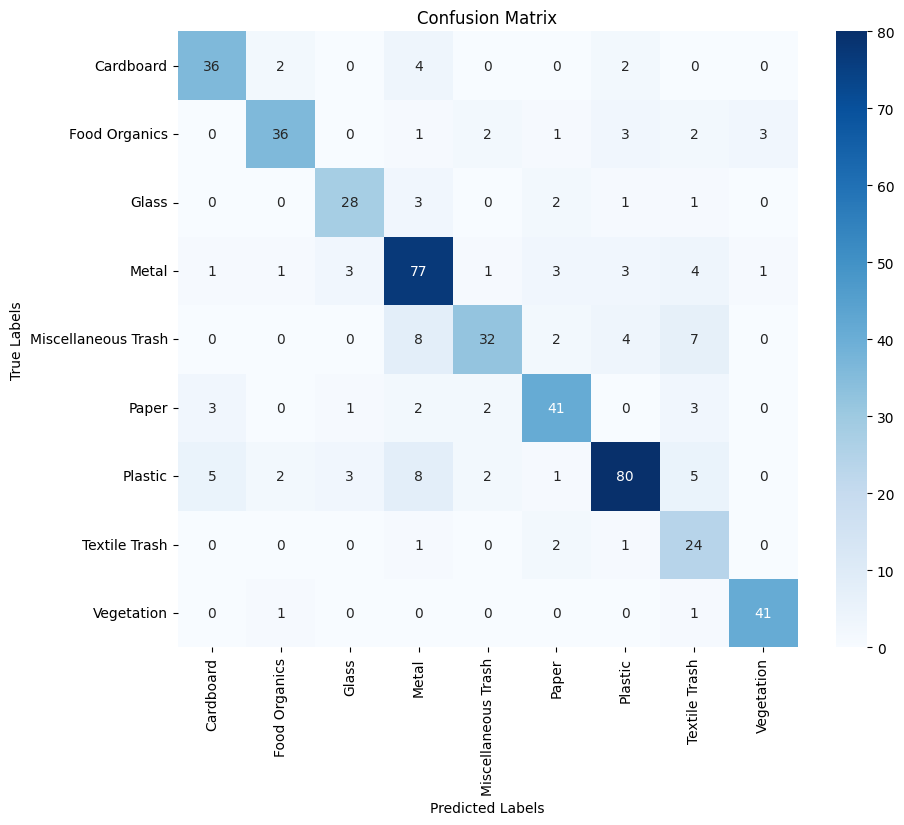

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================
# Final Evaluation with Confusion Matrix
# =============================================
print("\nFinal Evaluation:")

# Load the best saved model
ft_model.load_state_dict(torch.load(CHECKPOINT_PATH))

# Evaluate on the test set
test_acc = evaluate(ft_model, test_loader, device)
print(f"Test Accuracy: {test_acc:.2%}")

# Calculate confusion matrix
all_labels = []
all_preds = []

ft_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ft_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# Path to the custom dataset
CUSTOM_DATA_PATH = "/kaggle/input/last-test/test"

# Load custom dataset
custom_dataset = datasets.ImageFolder(CUSTOM_DATA_PATH, transform=val_transform)
custom_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



Evaluating on Custom Dataset...


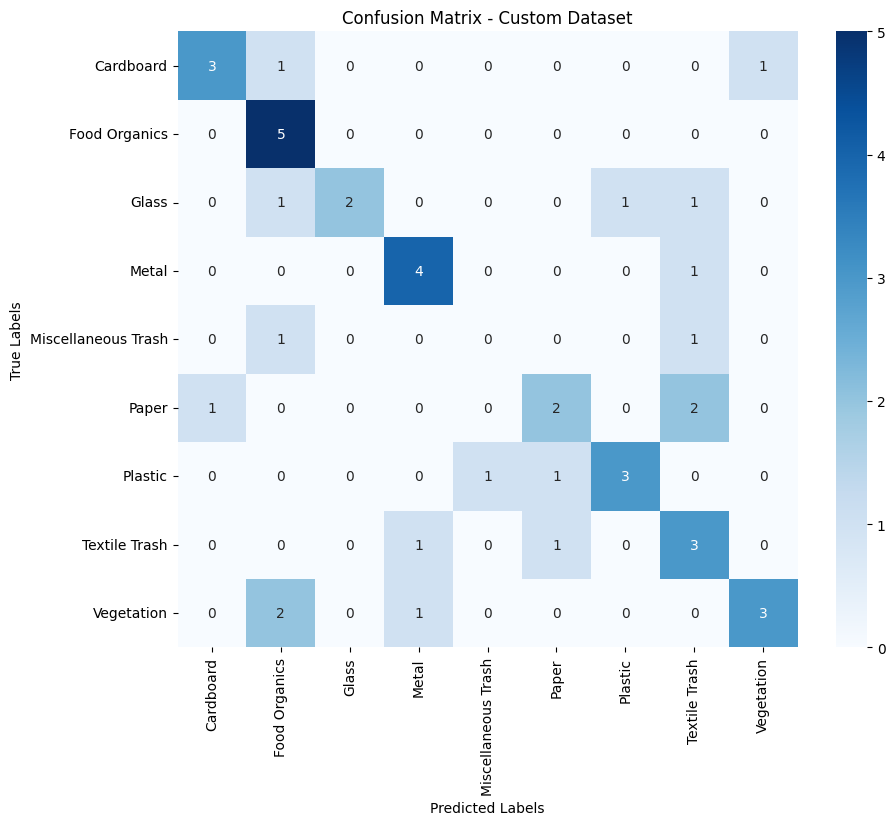

Custom Dataset Accuracy: 58.14%


In [ ]:
print("\nEvaluating on Custom Dataset...")
all_custom_labels = []
all_custom_preds = []

ft_model.eval()
with torch.no_grad():
    for inputs, labels in custom_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ft_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_custom_labels.extend(labels.cpu().numpy())
        all_custom_preds.extend(preds.cpu().numpy())

# Compute confusion matrix for custom data
custom_cm = confusion_matrix(all_custom_labels, all_custom_preds)

# Plot confusion matrix for custom data
plt.figure(figsize=(10, 8))
sns.heatmap(custom_cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Custom Dataset")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print custom dataset accuracy
custom_acc = (np.array(all_custom_preds) == np.array(all_custom_labels)).sum() / len(all_custom_labels)
print(f"Custom Dataset Accuracy: {custom_acc:.2%}")


In [ ]:
import torch
from PIL import Image
import torch.nn.functional as F

# Path to the single image
image_path = "/kaggle/input/test-cutom/test/Food Organics/download.jpg"

# Load the image
image = Image.open(image_path).convert("RGB")

# Apply the same transformation used for validation
processed_image = val_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Set the model to evaluation mode
ft_model.eval()

# Perform inference
with torch.no_grad():
    output = ft_model(processed_image)

    # Apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)

    # Get the predicted class probabilities for each class
    for idx, prob in enumerate(probabilities[0]):
        print(f"Class: {classes[idx]}, Probability: {prob.item():.4f}")


Class: Cardboard, Probability: 0.9903
Class: Food Organics, Probability: 0.0005
Class: Glass, Probability: 0.0000
Class: Metal, Probability: 0.0004
Class: Miscellaneous Trash, Probability: 0.0010
Class: Paper, Probability: 0.0058
Class: Plastic, Probability: 0.0012
Class: Textile Trash, Probability: 0.0005
Class: Vegetation, Probability: 0.0003


Train Set Size: 3511
Validation Set Size: 752
Test Set Size: 753
Pretraining Epoch [1/30], Loss: 2.7708
Pretraining Epoch [2/30], Loss: 2.7754
Pretraining Epoch [3/30], Loss: 2.7740
Pretraining Epoch [4/30], Loss: 2.7725
Pretraining Epoch [5/30], Loss: 2.7714
Pretraining Epoch [6/30], Loss: 2.7712
Pretraining Epoch [7/30], Loss: 2.7710
Pretraining Epoch [8/30], Loss: 2.7721
Pretraining Epoch [9/30], Loss: 2.7692
Pretraining Epoch [10/30], Loss: 2.7698
Pretraining Epoch [11/30], Loss: 2.7727
Pretraining Epoch [12/30], Loss: 2.7708
Pretraining Epoch [13/30], Loss: 2.7709
Pretraining Epoch [14/30], Loss: 2.7706
Pretraining Epoch [15/30], Loss: 2.7707
Pretraining Epoch [16/30], Loss: 2.7699
Pretraining Epoch [17/30], Loss: 2.7704
Pretraining Epoch [18/30], Loss: 2.7703
Pretraining Epoch [19/30], Loss: 2.7705
Pretraining Epoch [20/30], Loss: 2.7706
Pretraining Epoch [21/30], Loss: 2.7698
Pretraining Epoch [22/30], Loss: 2.7703
Pretraining Epoch [23/30], Loss: 2.7697
Pretraining Epoch [24/30

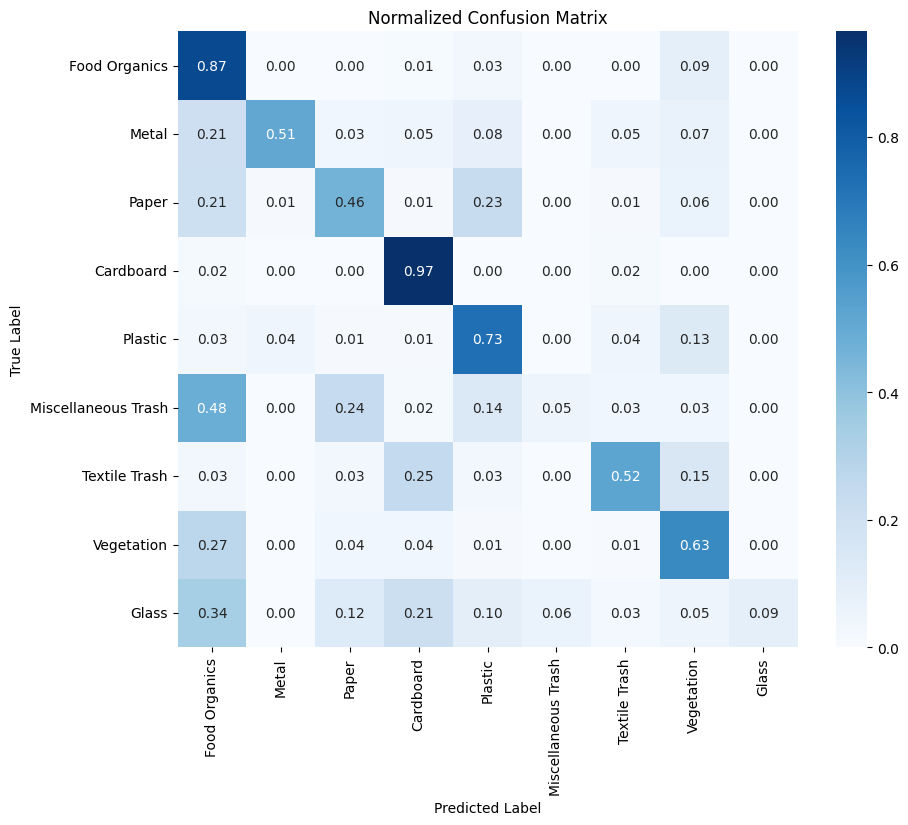

Epoch [2/30], Loss: 1.0639, Accuracy: 63.23%
Validation Loss: 0.9358, Validation Accuracy: 66.62%
Best model saved with validation accuracy: 66.62%


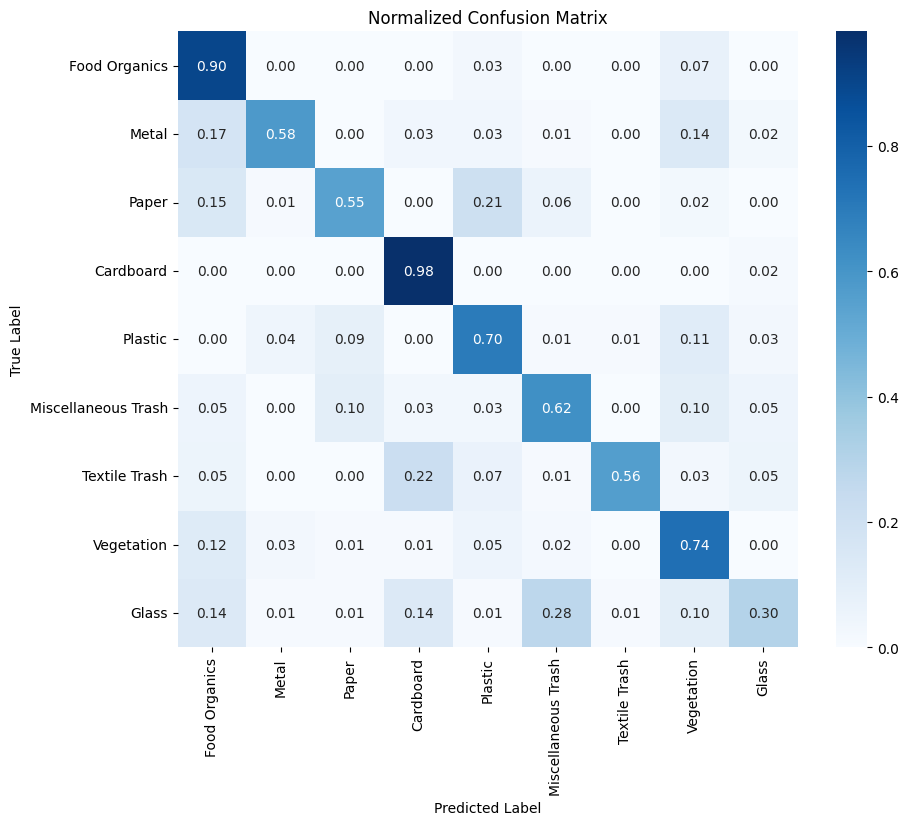

Epoch [3/30], Loss: 0.7380, Accuracy: 74.02%
Validation Loss: 0.7163, Validation Accuracy: 73.01%
Best model saved with validation accuracy: 73.01%


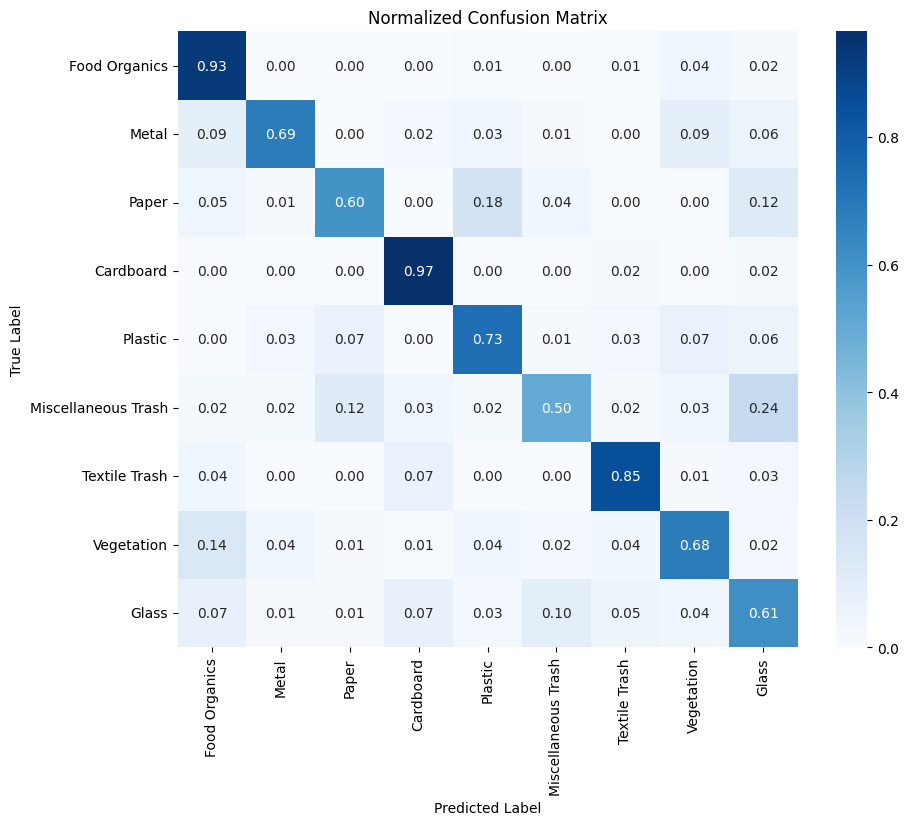

Epoch [4/30], Loss: 0.5603, Accuracy: 80.49%
Validation Loss: 0.6532, Validation Accuracy: 75.93%
Best model saved with validation accuracy: 75.93%


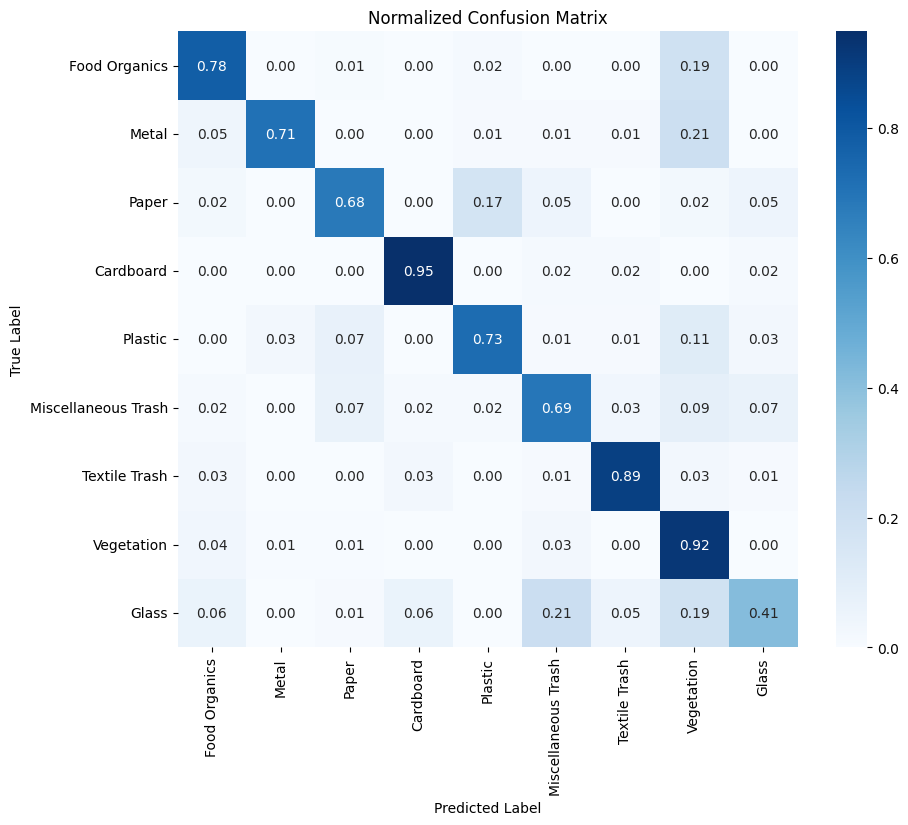

Epoch [5/30], Loss: 0.4379, Accuracy: 85.62%
Validation Loss: 0.5733, Validation Accuracy: 79.12%
Best model saved with validation accuracy: 79.12%


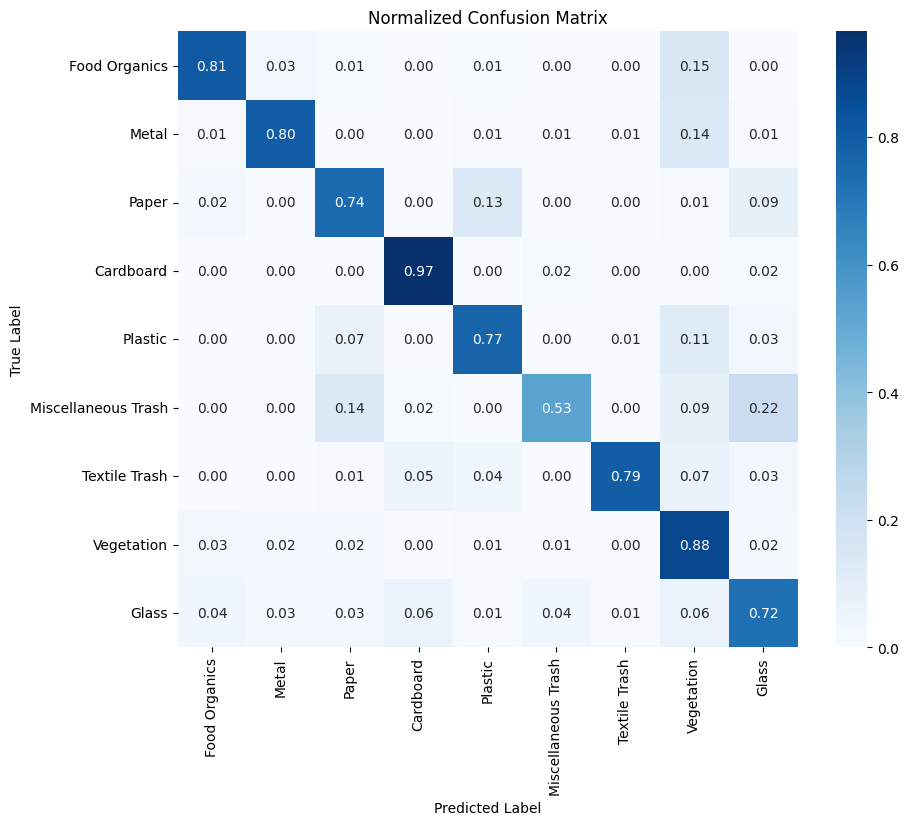

Epoch [6/30], Loss: 0.3564, Accuracy: 88.15%
Validation Loss: 0.5201, Validation Accuracy: 81.52%
Best model saved with validation accuracy: 81.52%


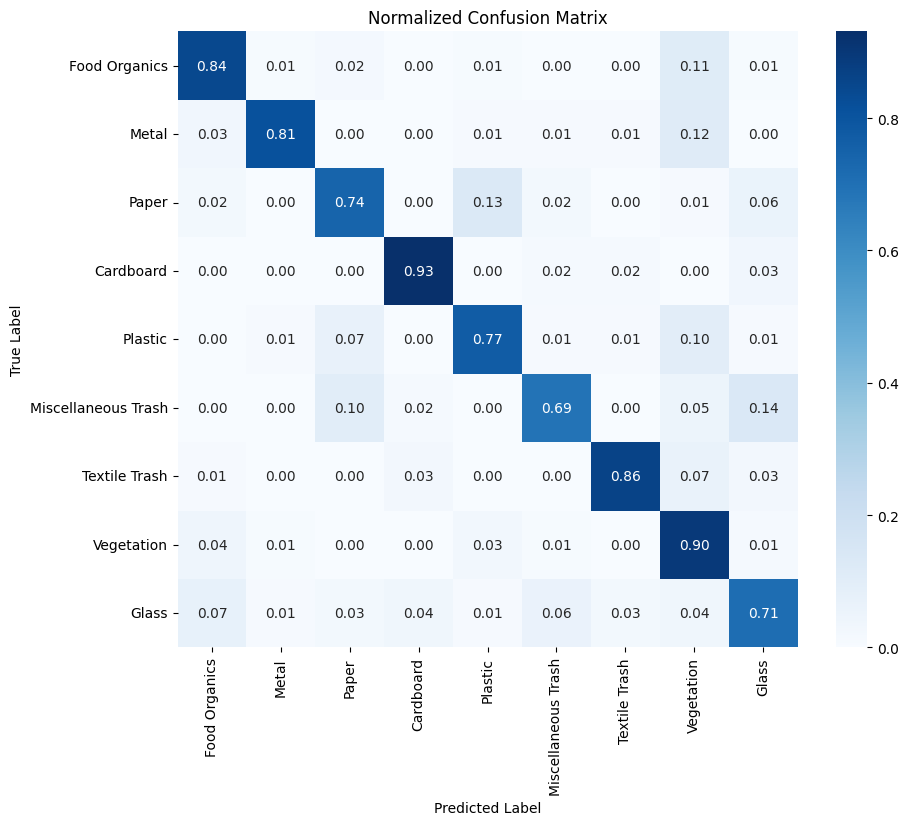

Epoch [7/30], Loss: 0.2795, Accuracy: 91.31%
Validation Loss: 0.5490, Validation Accuracy: 81.91%
Best model saved with validation accuracy: 81.91%


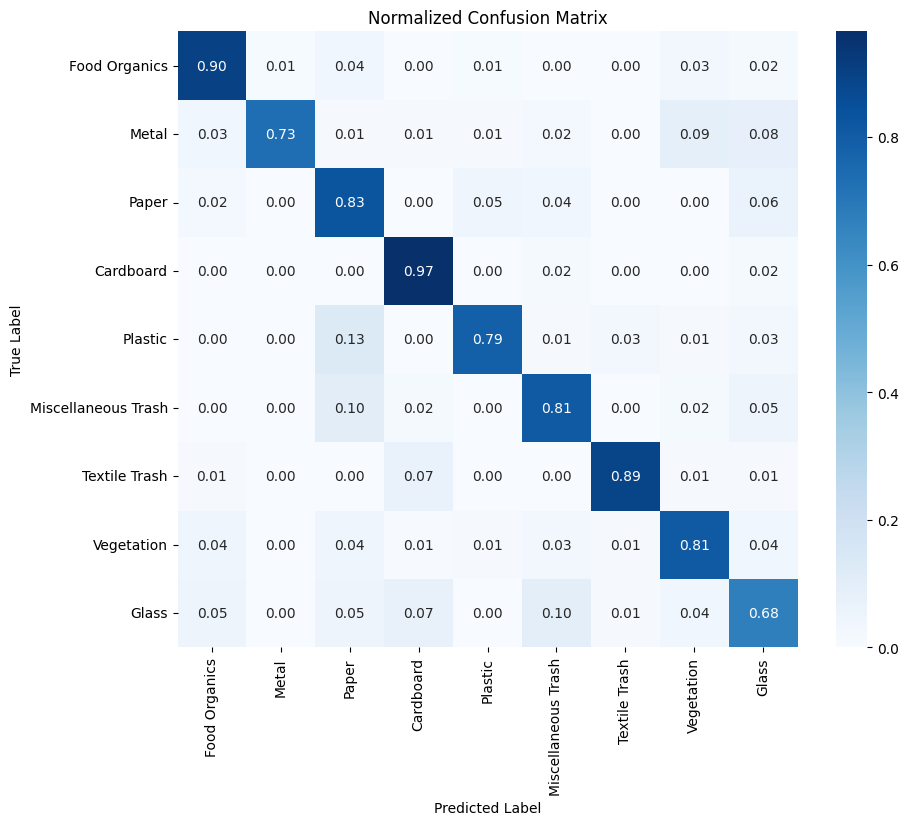

Epoch [8/30], Loss: 0.2114, Accuracy: 93.76%
Validation Loss: 0.5025, Validation Accuracy: 83.11%
Best model saved with validation accuracy: 83.11%


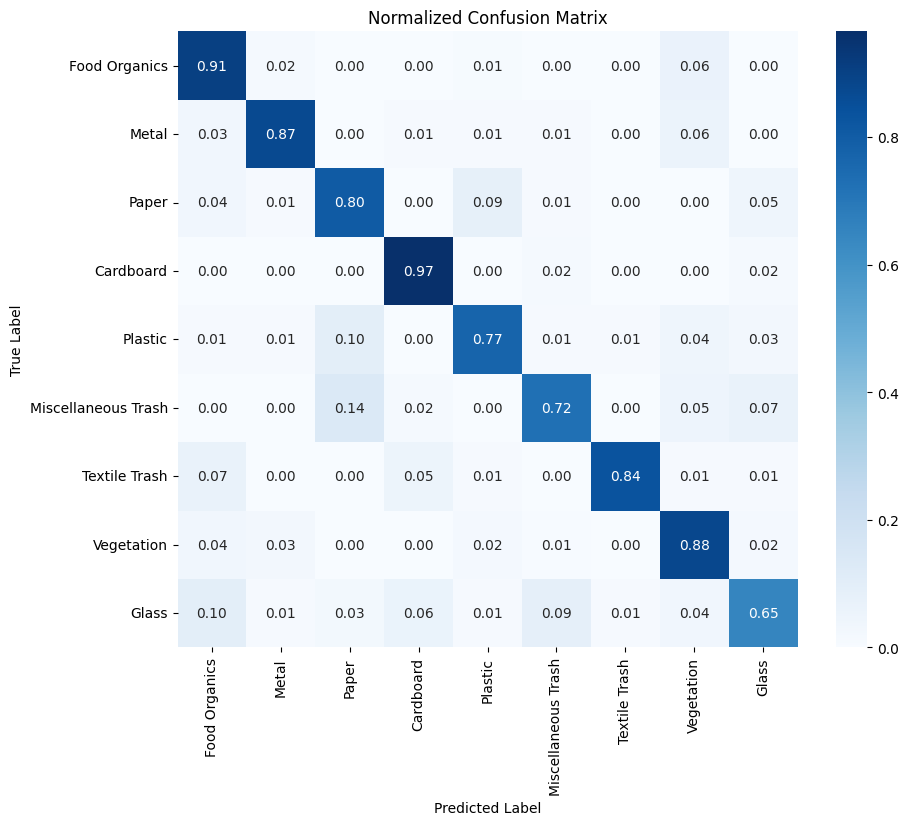

Epoch [9/30], Loss: 0.1577, Accuracy: 95.73%
Validation Loss: 0.5176, Validation Accuracy: 82.85%


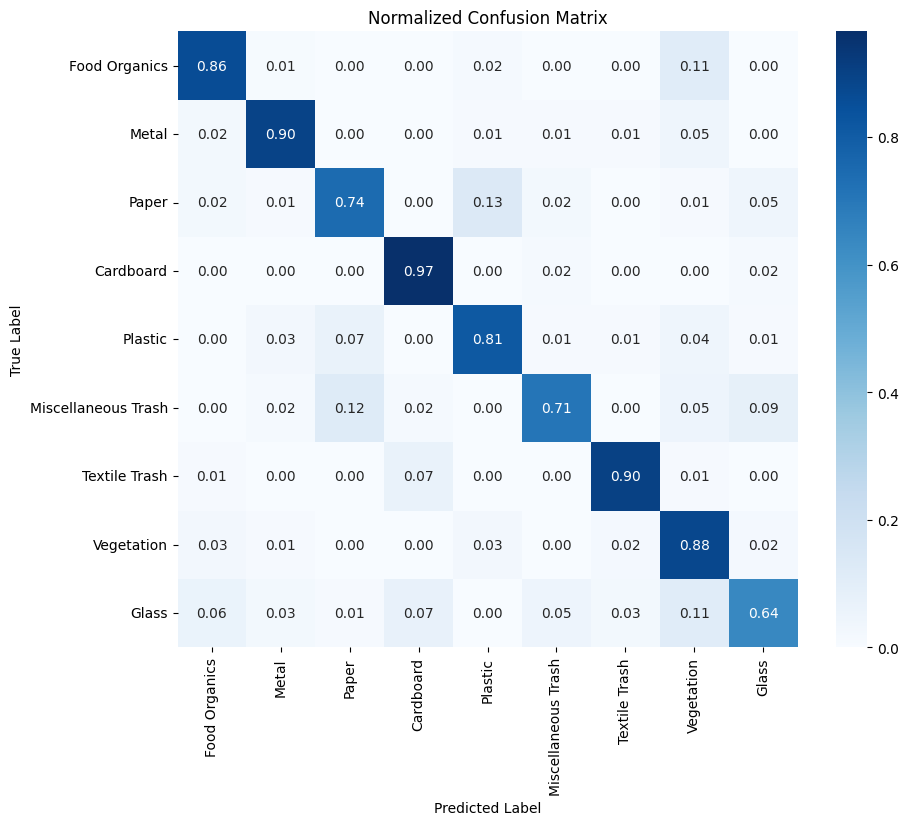

Epoch [10/30], Loss: 0.1163, Accuracy: 97.38%
Validation Loss: 0.5280, Validation Accuracy: 82.98%


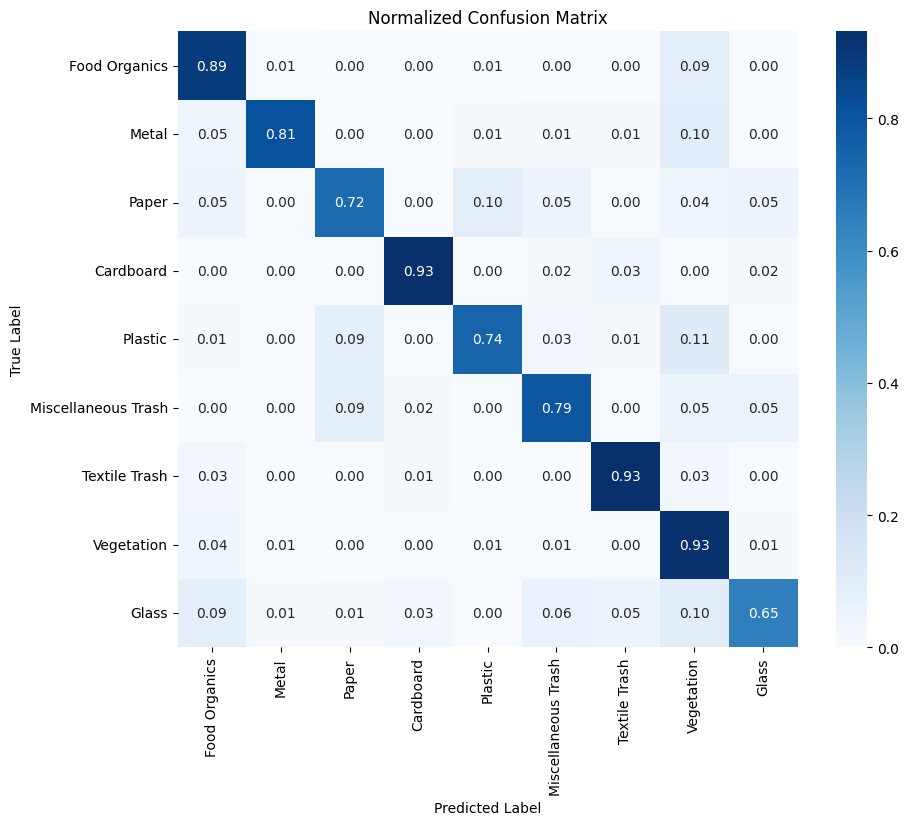

Epoch [11/30], Loss: 0.1012, Accuracy: 97.75%
Validation Loss: 0.4891, Validation Accuracy: 84.44%
Best model saved with validation accuracy: 84.44%


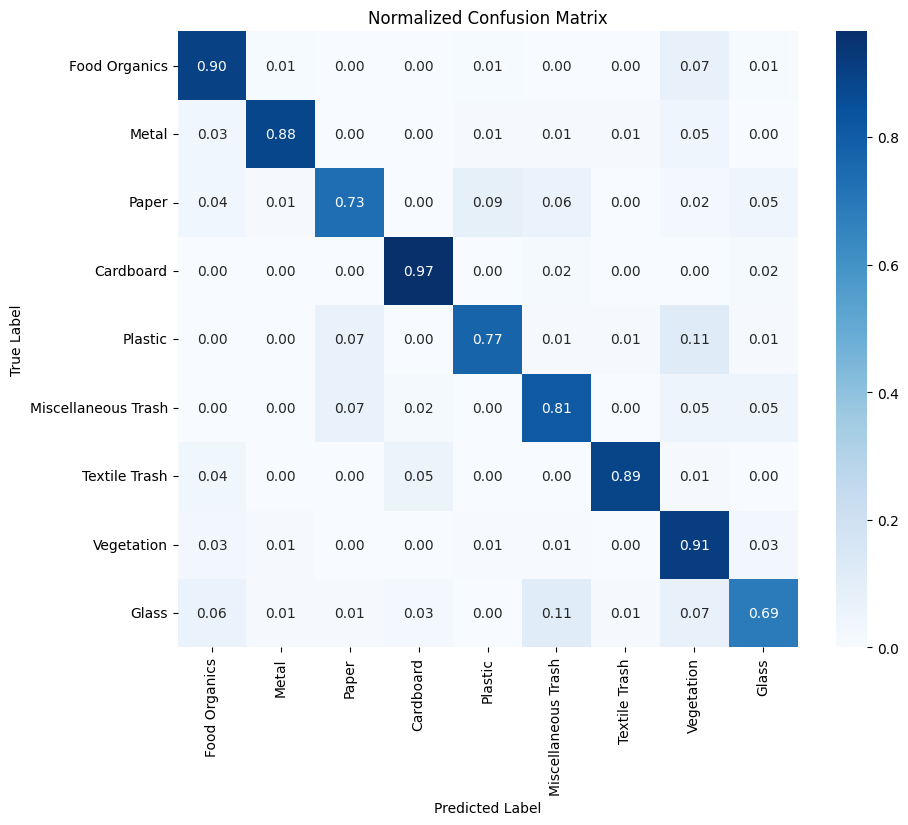

Epoch [12/30], Loss: 0.0607, Accuracy: 99.06%
Validation Loss: 0.5727, Validation Accuracy: 82.45%


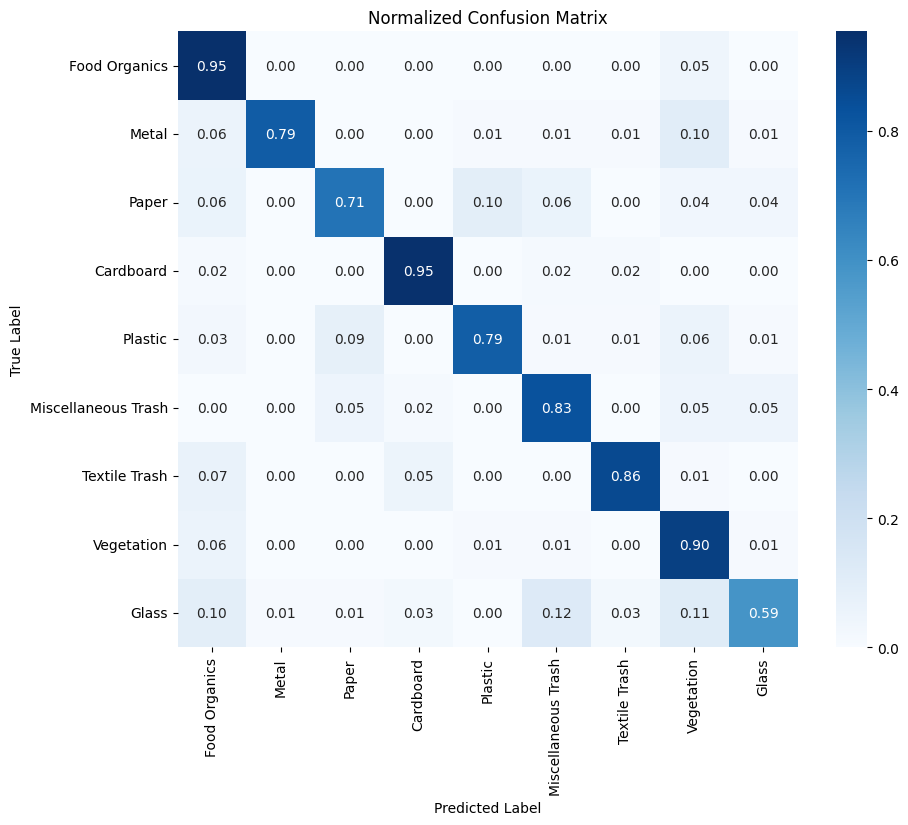

Epoch [13/30], Loss: 0.0476, Accuracy: 99.29%
Validation Loss: 0.5629, Validation Accuracy: 83.91%


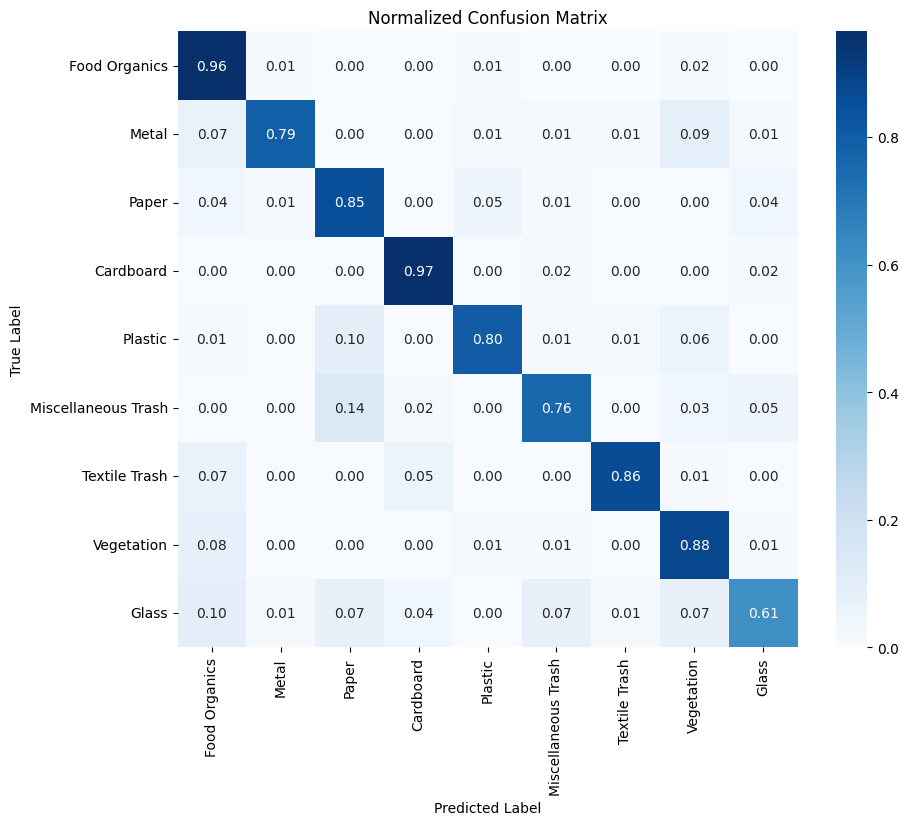

Epoch [14/30], Loss: 0.0291, Accuracy: 99.80%
Validation Loss: 0.5390, Validation Accuracy: 84.04%


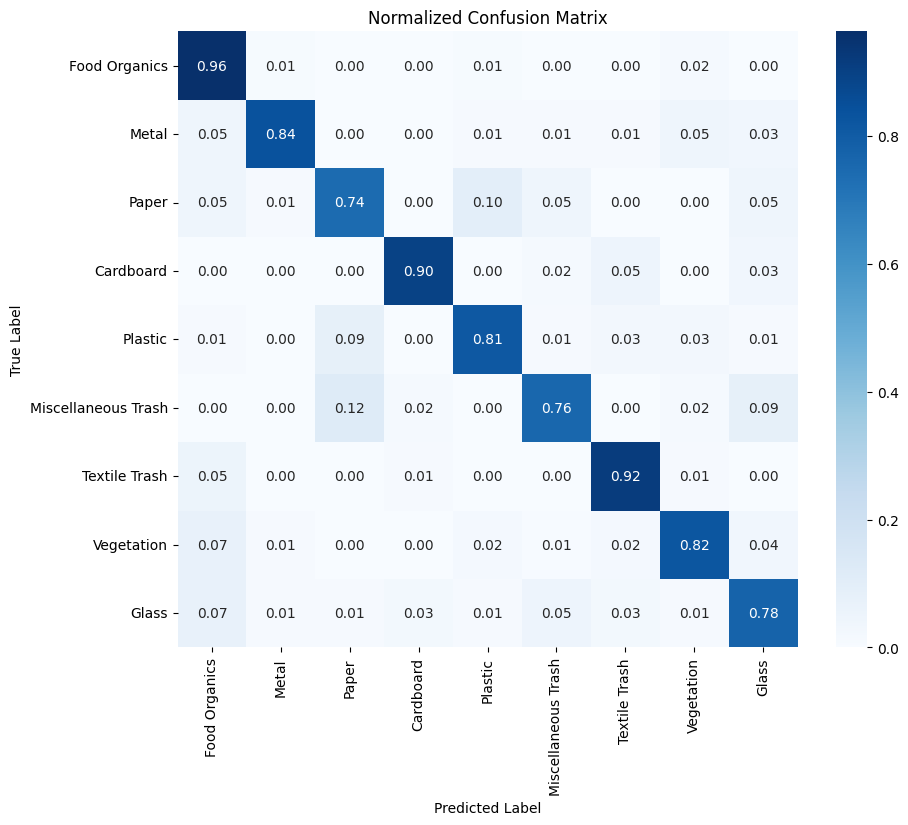

Epoch [15/30], Loss: 0.0376, Accuracy: 99.20%
Validation Loss: 0.5185, Validation Accuracy: 85.37%
Best model saved with validation accuracy: 85.37%


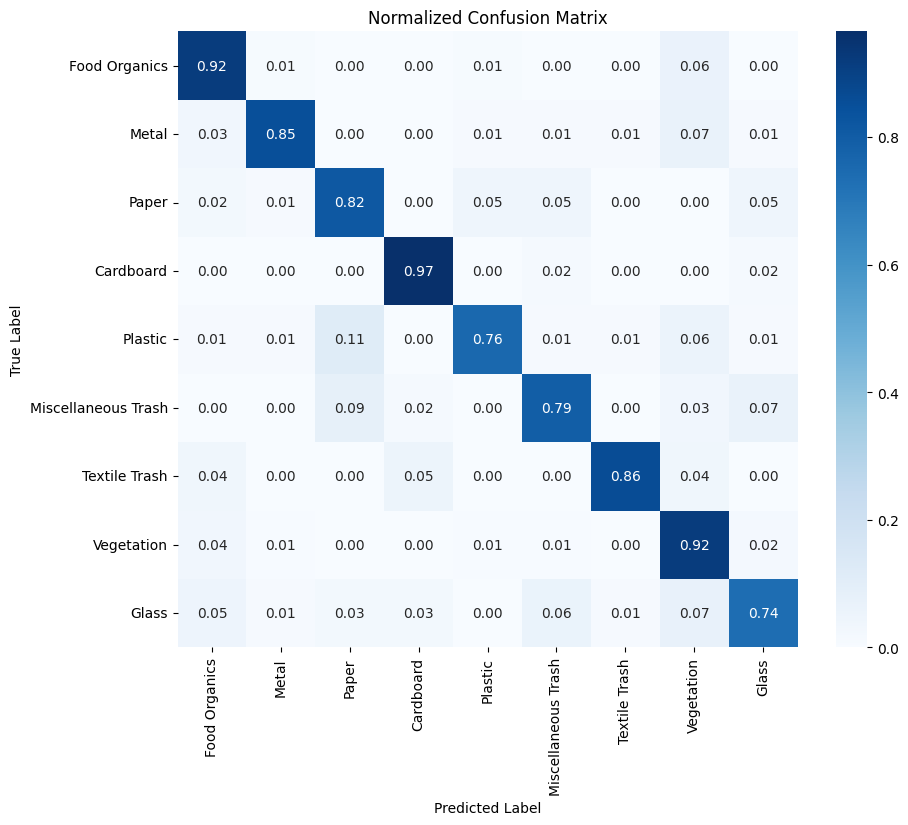

Epoch [16/30], Loss: 0.0145, Accuracy: 100.00%
Validation Loss: 0.5669, Validation Accuracy: 84.44%


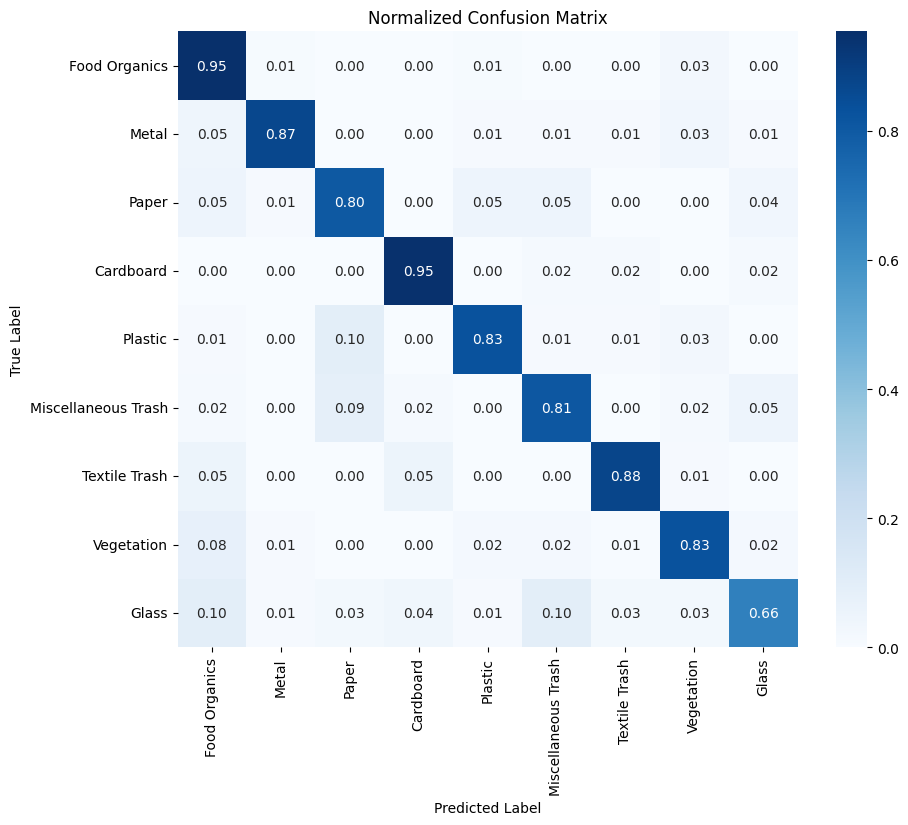

Epoch [17/30], Loss: 0.0133, Accuracy: 99.97%
Validation Loss: 0.5849, Validation Accuracy: 84.44%


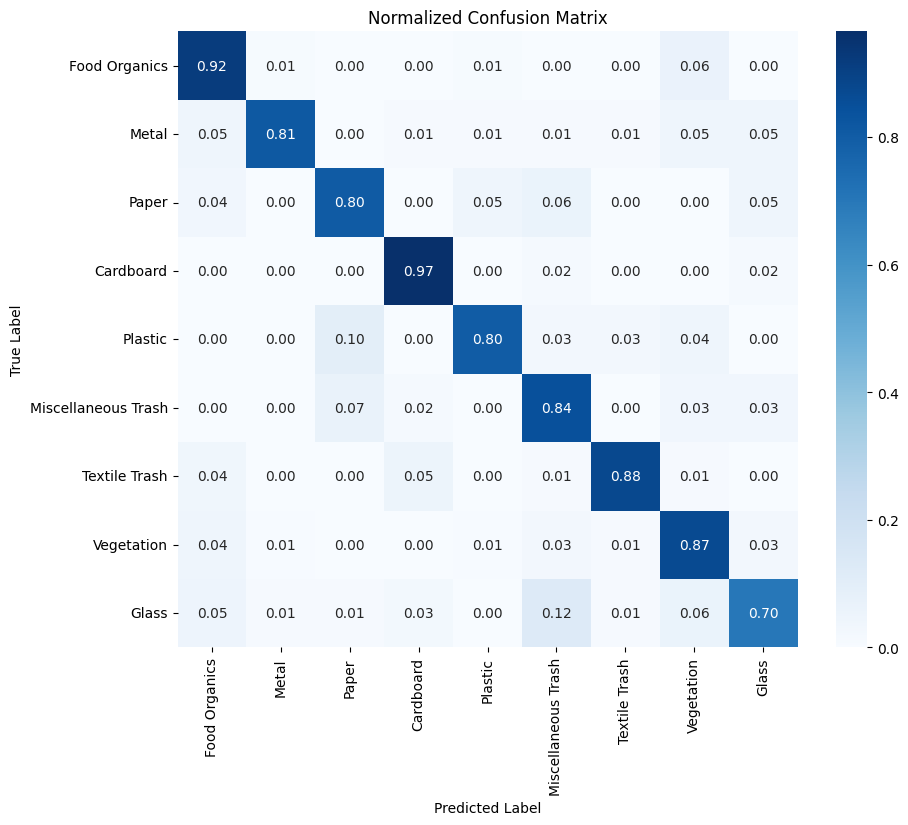

Epoch [18/30], Loss: 0.0107, Accuracy: 100.00%
Validation Loss: 0.5818, Validation Accuracy: 86.17%
Best model saved with validation accuracy: 86.17%


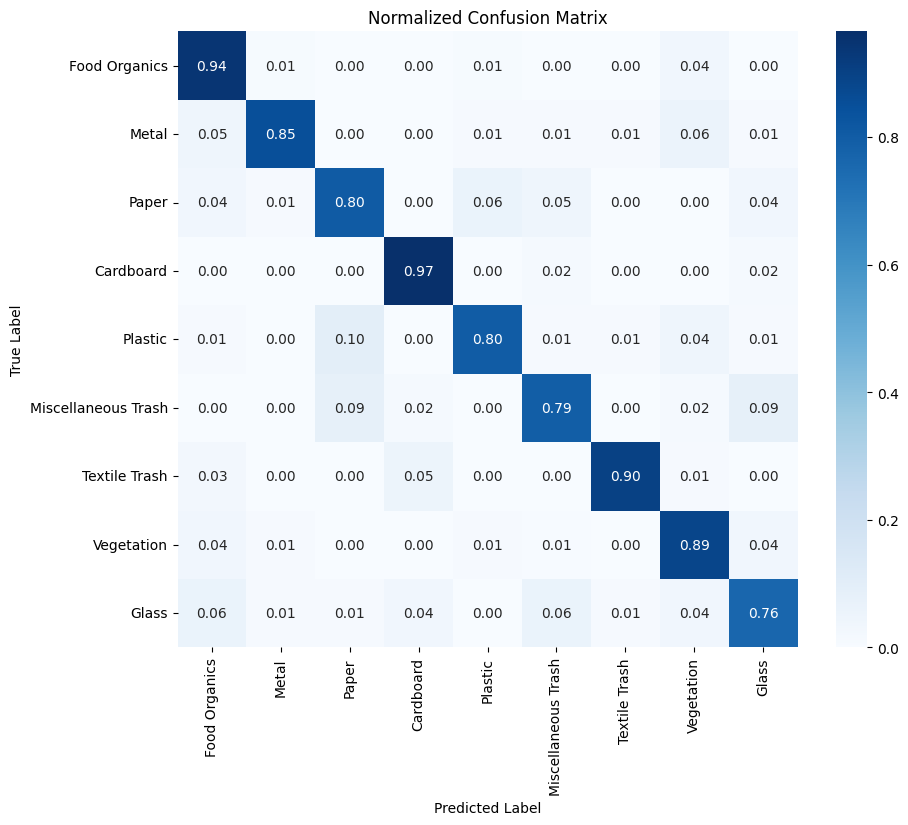

Epoch [19/30], Loss: 0.0066, Accuracy: 100.00%
Validation Loss: 0.6079, Validation Accuracy: 85.24%


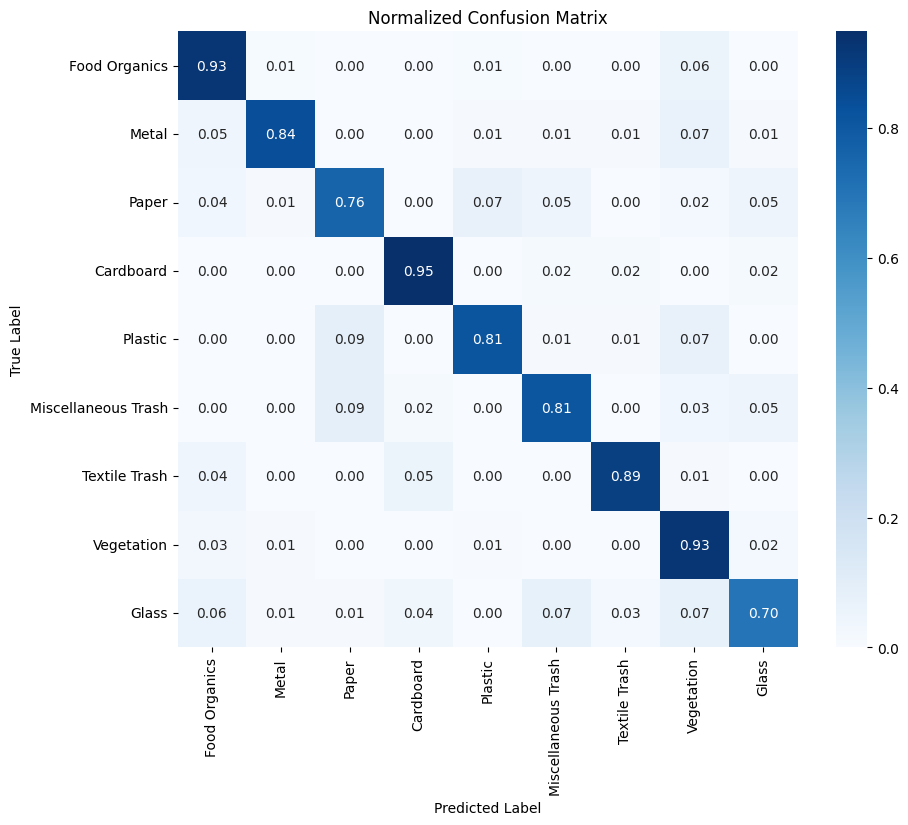

Epoch [20/30], Loss: 0.0047, Accuracy: 100.00%
Validation Loss: 0.6019, Validation Accuracy: 85.51%


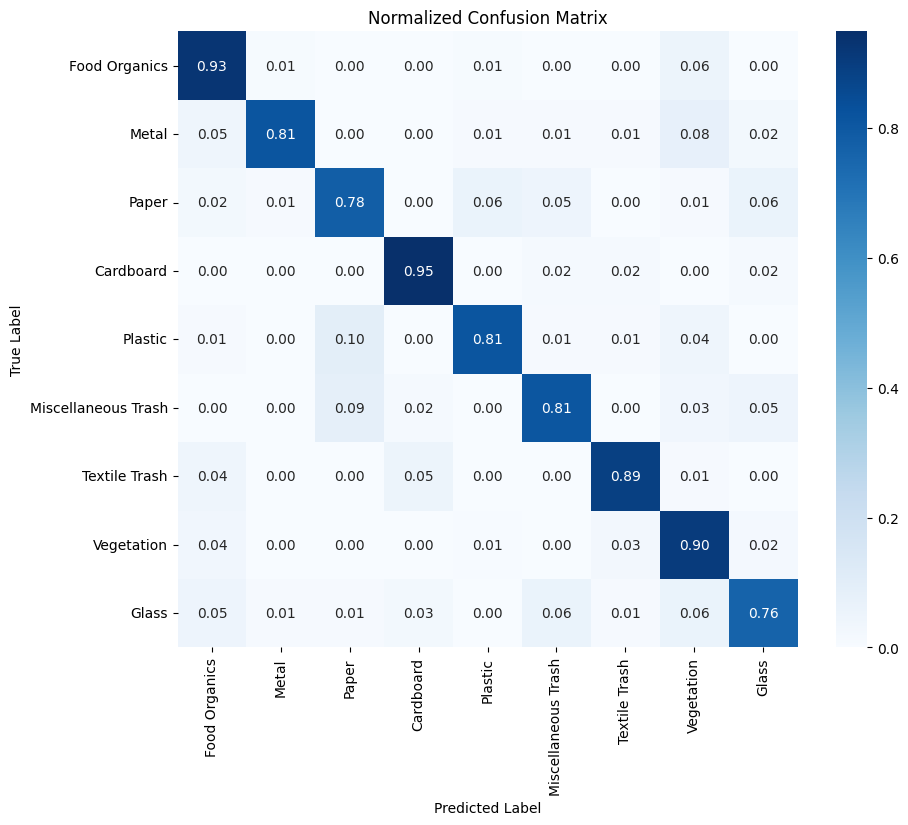

Epoch [21/30], Loss: 0.0038, Accuracy: 100.00%
Validation Loss: 0.6317, Validation Accuracy: 85.24%


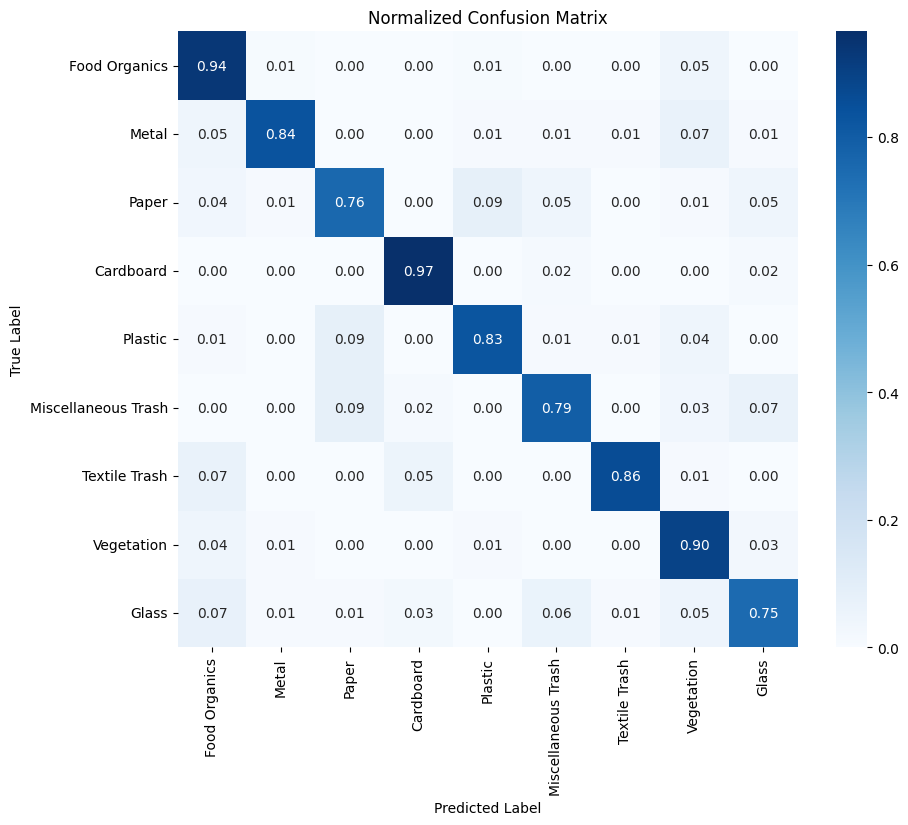

Epoch [22/30], Loss: 0.0033, Accuracy: 100.00%
Validation Loss: 0.6352, Validation Accuracy: 85.37%


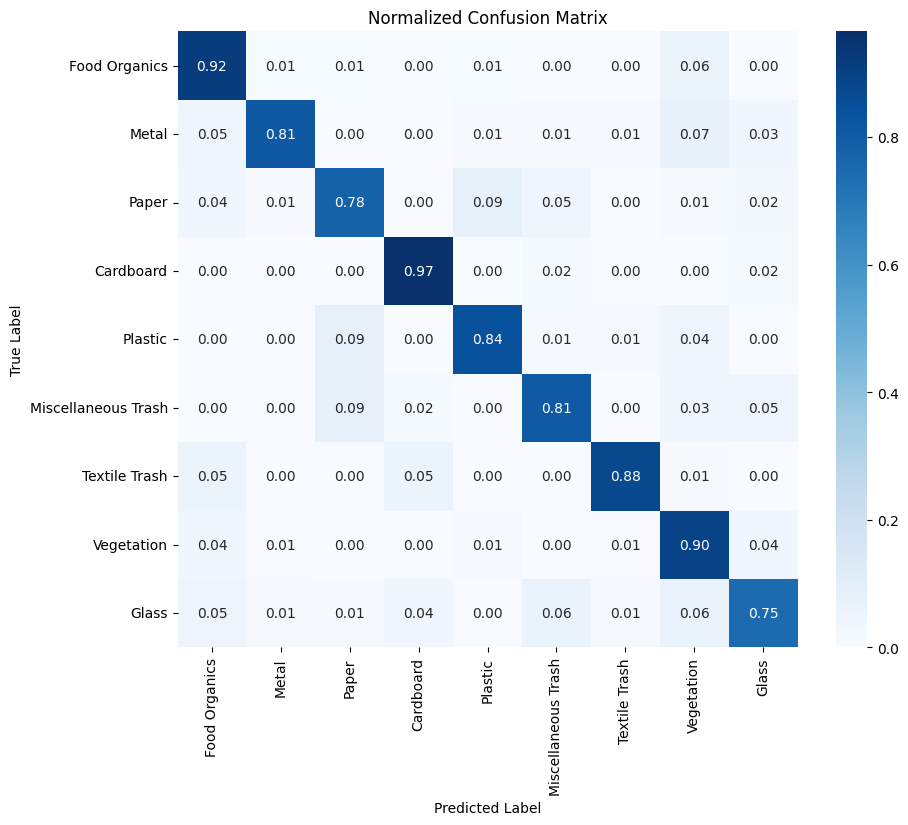

Epoch [23/30], Loss: 0.0027, Accuracy: 100.00%
Validation Loss: 0.6423, Validation Accuracy: 86.04%


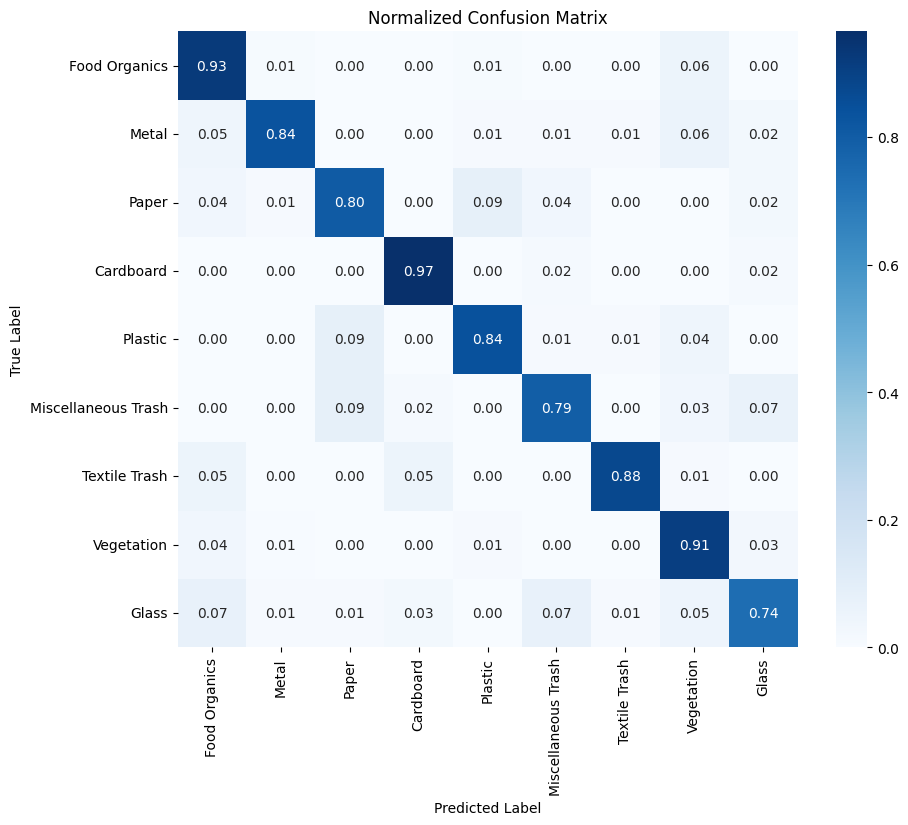

Epoch [24/30], Loss: 0.0022, Accuracy: 100.00%
Validation Loss: 0.6573, Validation Accuracy: 85.77%


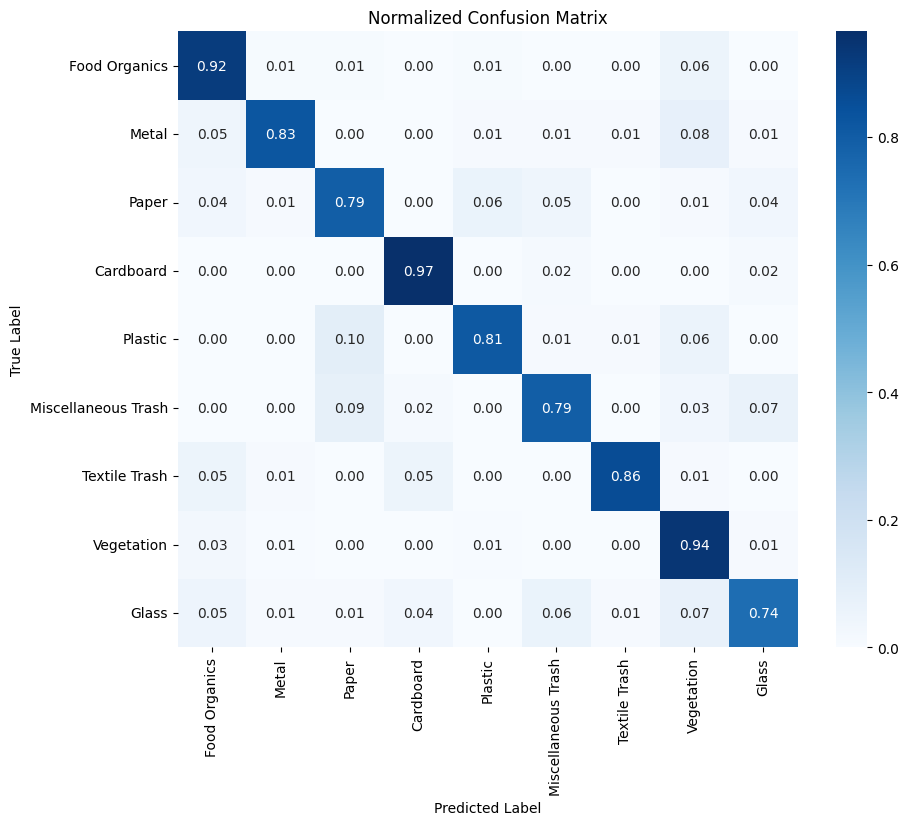

Epoch [25/30], Loss: 0.0020, Accuracy: 100.00%
Validation Loss: 0.6673, Validation Accuracy: 85.90%


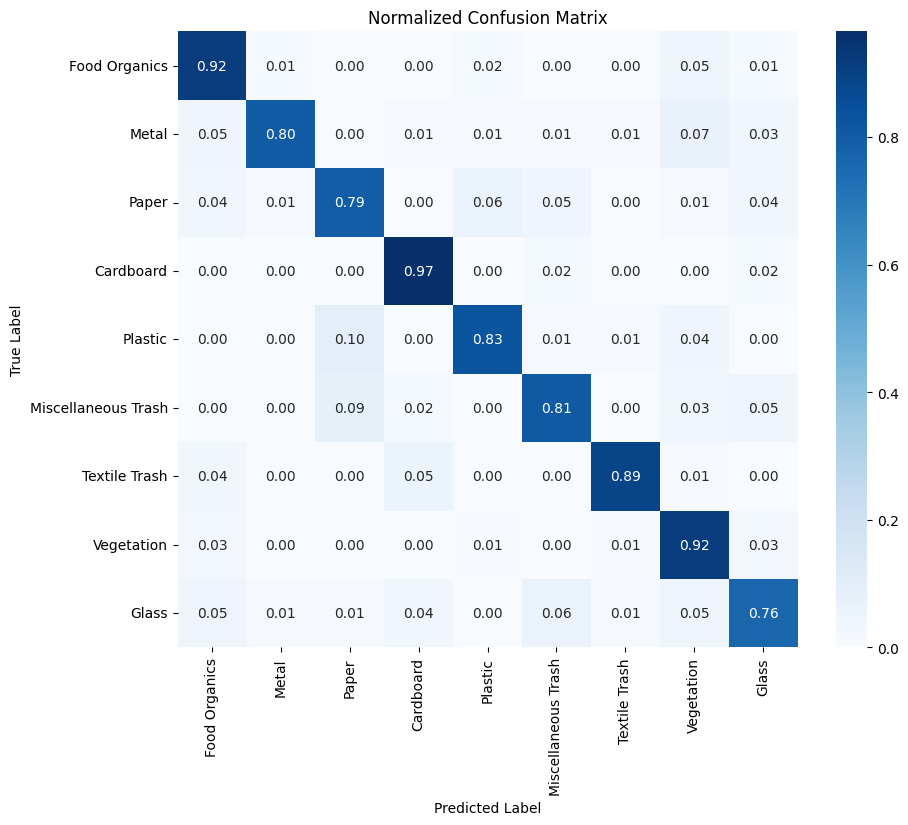

Epoch [26/30], Loss: 0.0017, Accuracy: 100.00%
Validation Loss: 0.6743, Validation Accuracy: 86.17%


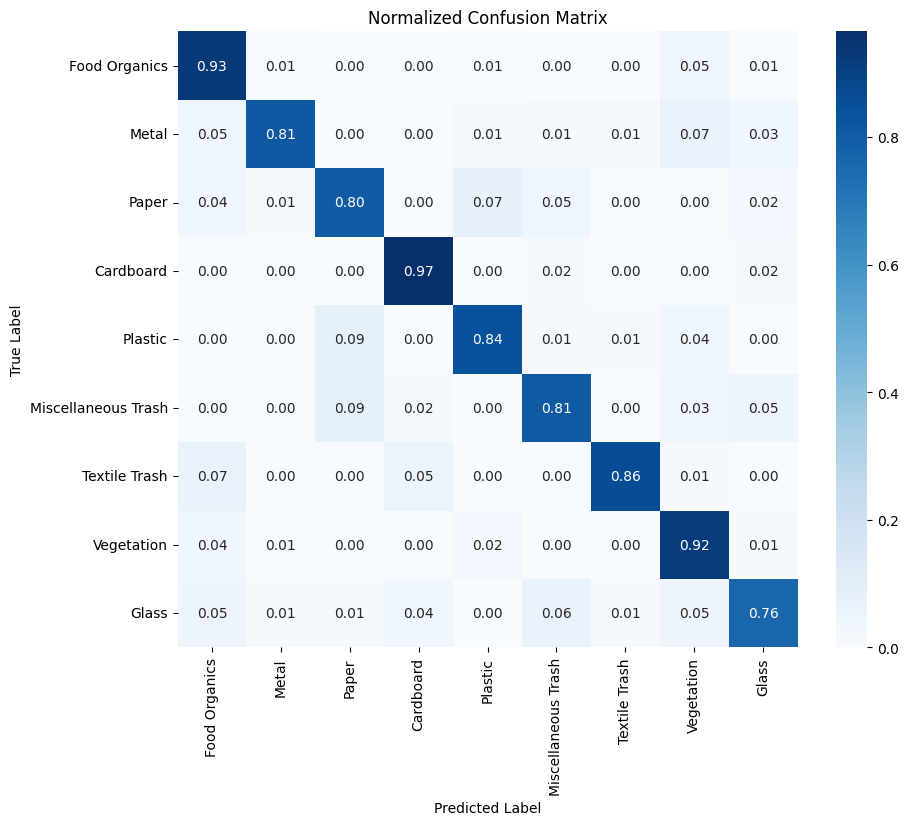

Epoch [27/30], Loss: 0.0014, Accuracy: 100.00%
Validation Loss: 0.6826, Validation Accuracy: 86.04%


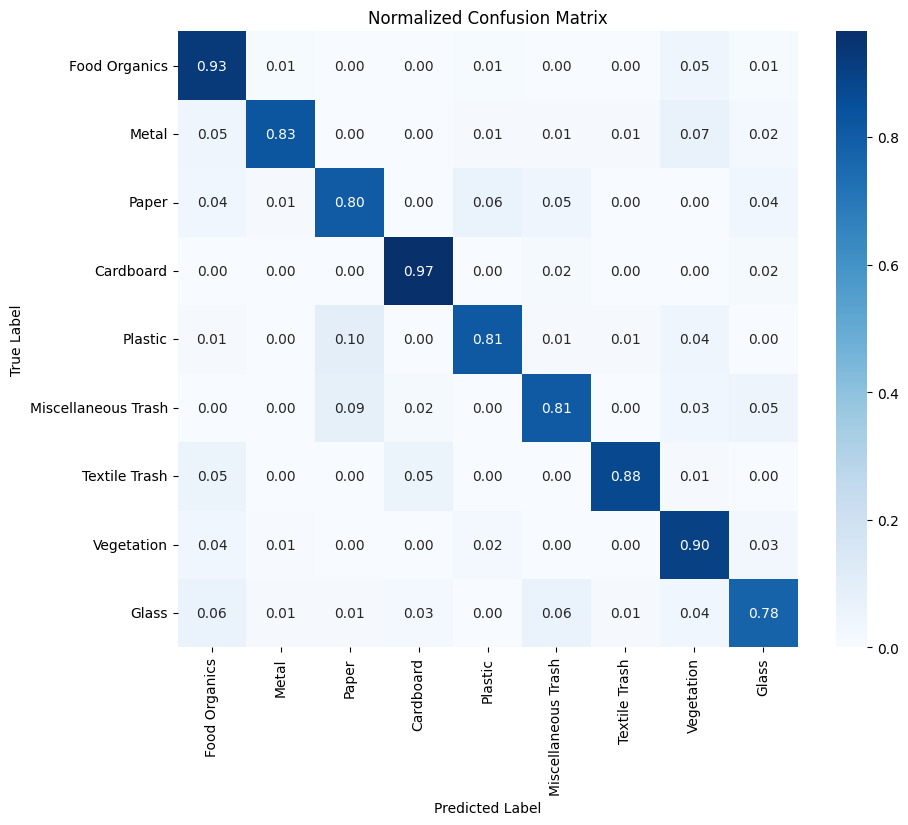

Epoch [28/30], Loss: 0.0013, Accuracy: 100.00%
Validation Loss: 0.6948, Validation Accuracy: 85.37%


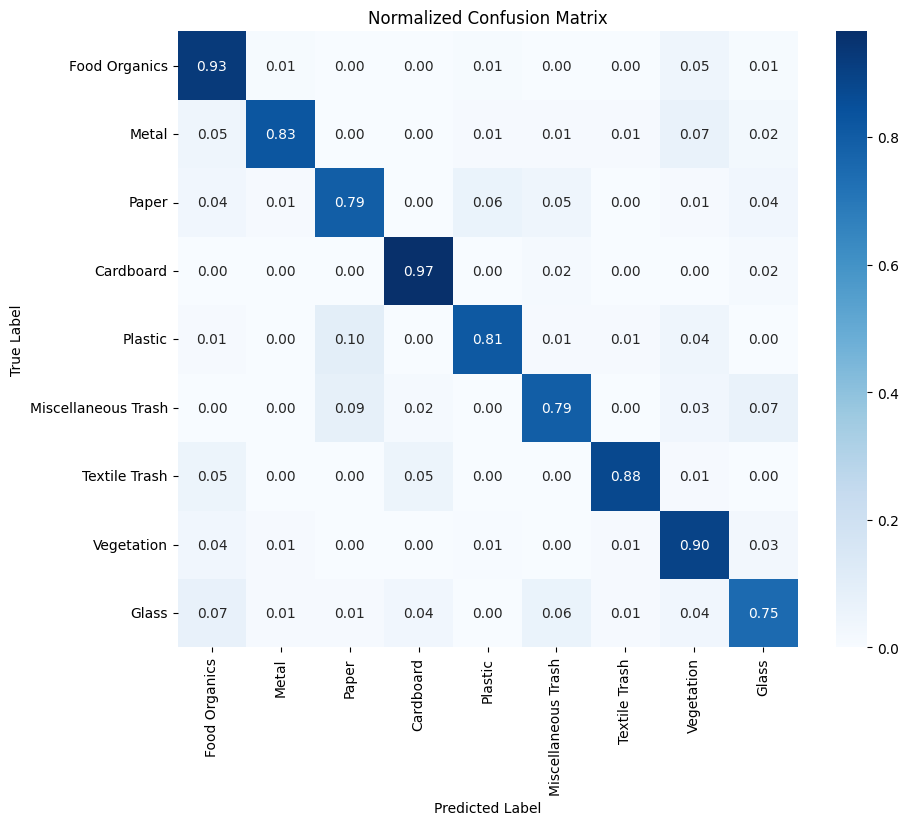

Epoch [29/30], Loss: 0.0011, Accuracy: 100.00%
Validation Loss: 0.6952, Validation Accuracy: 85.90%


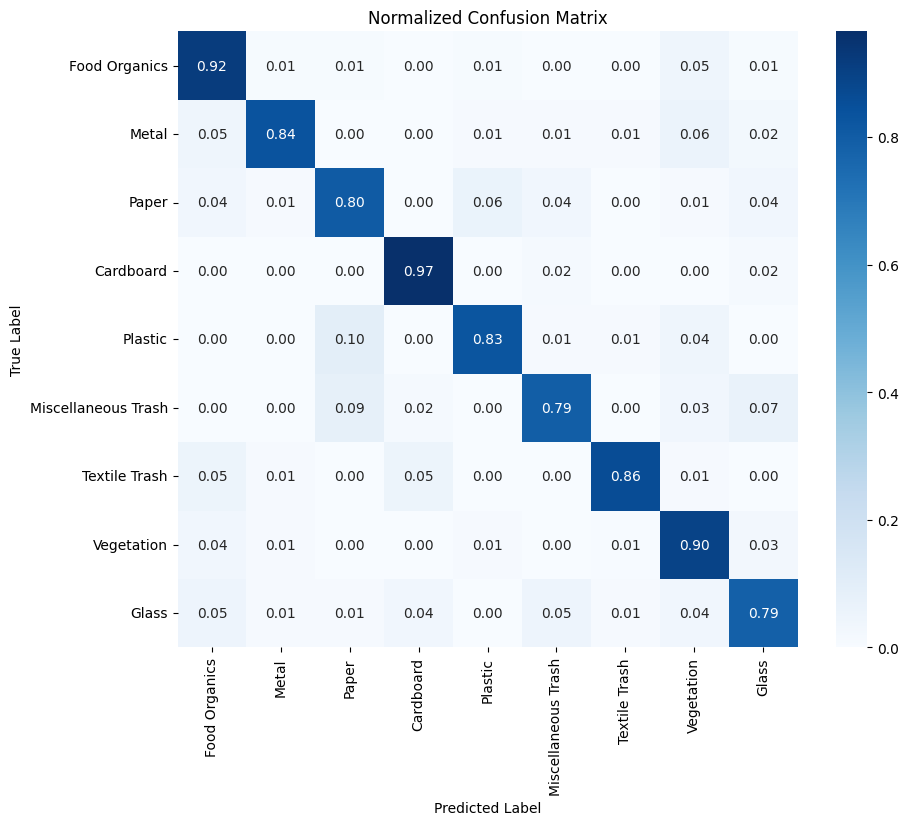

Epoch [30/30], Loss: 0.0010, Accuracy: 100.00%
Validation Loss: 0.7046, Validation Accuracy: 85.51%


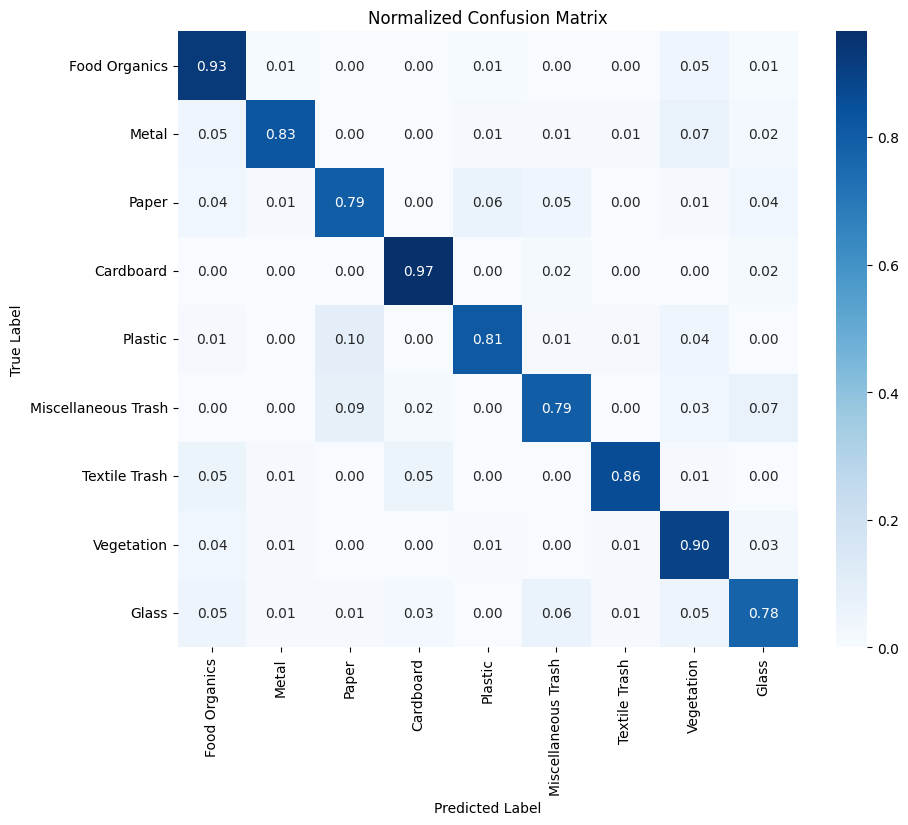

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# --- Custom Dataset Class ---
class CombinedDataset(Dataset):
    def __init__(self, realwaste_dir, custom_data_dir, transform=None):
        self.realwaste_dir = realwaste_dir
        self.custom_data_dir = custom_data_dir
        self.transform = transform

        # Get the list of all images and labels from both datasets
        self.realwaste_images, self.realwaste_labels = self.load_data(realwaste_dir)
        self.custom_images, self.custom_labels = self.load_data(custom_data_dir)

        # Combine the data from both datasets
        self.images = self.realwaste_images + self.custom_images
        self.labels = self.realwaste_labels + self.custom_labels

    def load_data(self, data_dir):
        images = []
        labels = []
        class_names = os.listdir(data_dir)
        class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

        # Load images and their corresponding labels
        for cls in class_names:
            class_path = os.path.join(data_dir, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append(img_path)
                labels.append(class_to_idx[cls])

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# --- NT-Xent Loss Function ---
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        """
        z_i and z_j are the feature representations of the two augmented views of the image.
        We calculate cosine similarity between these two.
        """
        # Normalize the feature vectors (L2 normalization)
        z_i = torch.nn.functional.normalize(z_i, p=2, dim=1)
        z_j = torch.nn.functional.normalize(z_j, p=2, dim=1)

        # Cosine similarity matrix
        similarity_matrix = torch.matmul(z_i, z_j.T) / self.temperature

        # Create labels (for contrastive loss, the correct match is the diagonal)
        labels = torch.arange(z_i.size(0)).to(z_i.device)

        # Calculate the loss using cross-entropy
        loss = torch.nn.functional.cross_entropy(similarity_matrix, labels)
        return loss


# --- Define SimCLR Model ---
class SimCLRModel(nn.Module):
    def __init__(self, base_model, feature_dim=512):
        super(SimCLRModel, self).__init__()
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove the final layer
        self.fc = nn.Linear(base_model.fc.in_features, feature_dim)

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)  # Flatten the feature map
        features = self.fc(features)
        return features


# --- Pretraining the SimCLR Model ---
def pretrain_simclr(model, train_loader, optimizer, criterion, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()

            # SimCLR pretraining typically involves two augmentations of the same image
            # Let's assume the dataset provides two augmentations of the same image
            # Here we are using a simple case, where images are passed directly to the model

            # Get features for the images
            features = model(images)

            # For simplicity, assume each image in the batch has a corresponding augmented pair in the batch
            # In practice, you will need to pass two augmentations of each image separately
            z_i = features[:len(features)//2]
            z_j = features[len(features)//2:]

            # Calculate the NT-Xent loss between z_i and z_j
            loss = criterion(z_i, z_j)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Pretraining Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


# --- Weighted Cross-Entropy Loss ---
def weighted_cross_entropy_loss(outputs, labels, class_weights):
    return nn.CrossEntropyLoss(weight=class_weights)(outputs, labels)


# --- Fine-Tuned Model ---
class FineTunedModel(nn.Module):
    def __init__(self, simclr_model, num_classes=9):
        super(FineTunedModel, self).__init__()
        self.encoder = simclr_model.encoder
        self.fc = nn.Linear(512, num_classes)  # Assuming feature size is 512

    def forward(self, x):
        features = self.encoder(x)
        features = torch.flatten(features, 1)  # Ensure compatibility
        return self.fc(features)


# --- Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# --- Fine-Tuning the Model ---
def fine_tune_model(train_loader, val_loader, model, criterion, optimizer, epochs=30, class_names=None):
    model.train()
    best_val_accuracy = 0.0

    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * total_correct / total_samples
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_samples += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_accuracy = 100 * val_correct / val_samples
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_finetuned_model.pth')
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}%")

        # Plot confusion matrix at the end of each epoch
        if class_names:
            plot_confusion_matrix(all_labels, all_preds, class_names)


# --- Main Pretraining and Fine-Tuning Process ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the SimCLR model
base_resnet = models.resnet18(pretrained=True)  # Example, can be replaced with any other backbone
simclr_model = SimCLRModel(base_model=base_resnet).to(device)

# Define transformations for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to your RealWaste and custom data directories
realwaste_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
custom_data_dir = "/kaggle/input/custom-data/custom_test"

# Create a combined dataset
combined_dataset = CombinedDataset(realwaste_dir, custom_data_dir, transform=transform)

# Split the combined dataset into train and validation sets
# Split the combined dataset into train, validation, and test sets
train_size = int(0.7 * len(combined_dataset))  # 70% for training
val_size = int(0.15 * len(combined_dataset))  # 15% for validation
test_size = len(combined_dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size, test_size])

# Create DataLoader for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optional: Print the number of samples in each set
print(f"Train Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

# Optimizer and criterion for pretraining (SimCLR loss, placeholder for now)
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-4)
pretrain_criterion = NTXentLoss(temperature=0.5)

# Pretrain the SimCLR model
pretrain_simclr(simclr_model, train_loader, optimizer, pretrain_criterion, epochs=50)

# Fine-tune the pre-trained model
fine_tuned_model = FineTunedModel(simclr_model).to(device)

# Define loss and optimizer for fine-tuning
class_weights = torch.tensor([1.0] * 9).to(device)  # Update with proper class weights if needed
criterion = lambda outputs, labels: weighted_cross_entropy_loss(outputs, labels, class_weights)
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=1e-5)

# Fine-tune the model
class_names = ['Food Organics', 'Metal', 'Paper', 'Cardboard', 'Plastic',
               'Miscellaneous Trash', 'Textile Trash', 'Vegetation', 'Glass']

fine_tune_model(train_loader, val_loader, fine_tuned_model, criterion, optimizer, epochs=20, class_names=class_names)


Epoch [1/5], Loss: 1.6901, Accuracy: 46.77%
Validation Loss: 1.1972, Validation Accuracy: 66.09%
Best model saved with validation accuracy: 66.09%


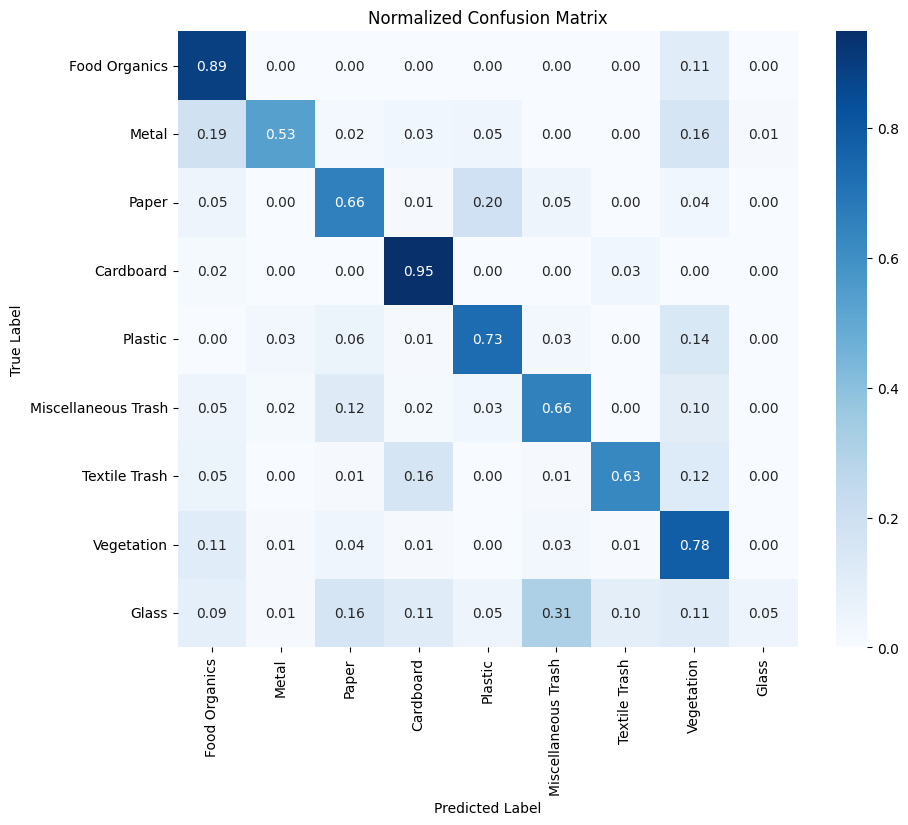

Epoch [2/5], Loss: 0.6791, Accuracy: 77.64%
Validation Loss: 0.6866, Validation Accuracy: 74.20%
Best model saved with validation accuracy: 74.20%


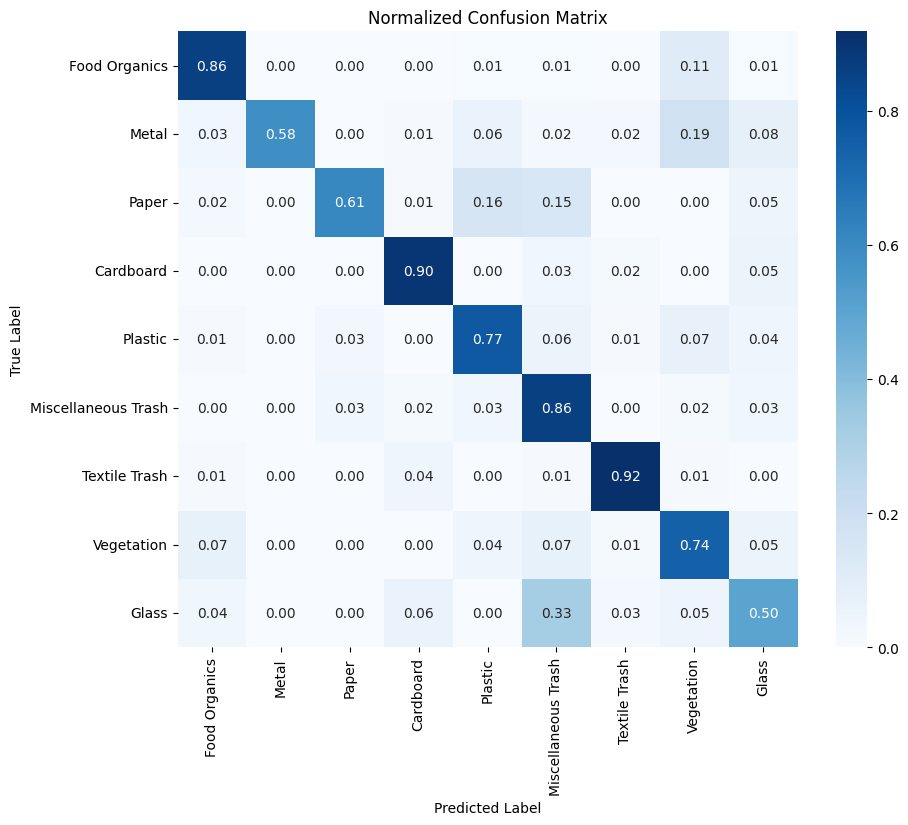

Epoch [3/5], Loss: 0.3238, Accuracy: 89.75%
Validation Loss: 0.6290, Validation Accuracy: 78.46%
Best model saved with validation accuracy: 78.46%


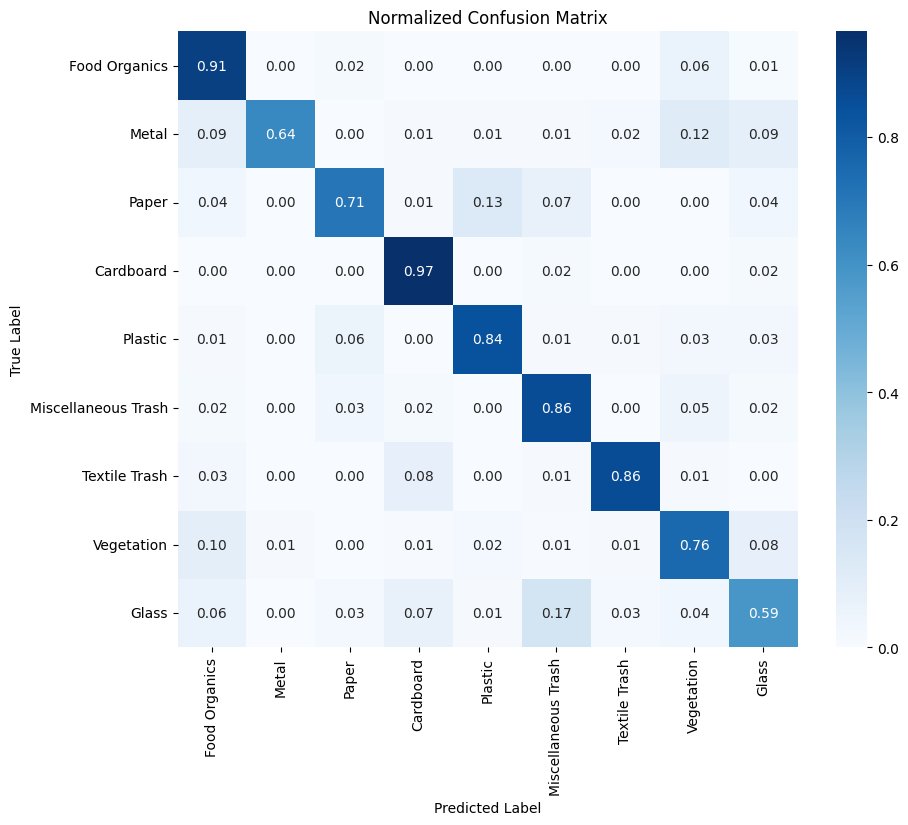

Epoch [4/5], Loss: 0.1830, Accuracy: 94.53%
Validation Loss: 0.5315, Validation Accuracy: 82.18%
Best model saved with validation accuracy: 82.18%


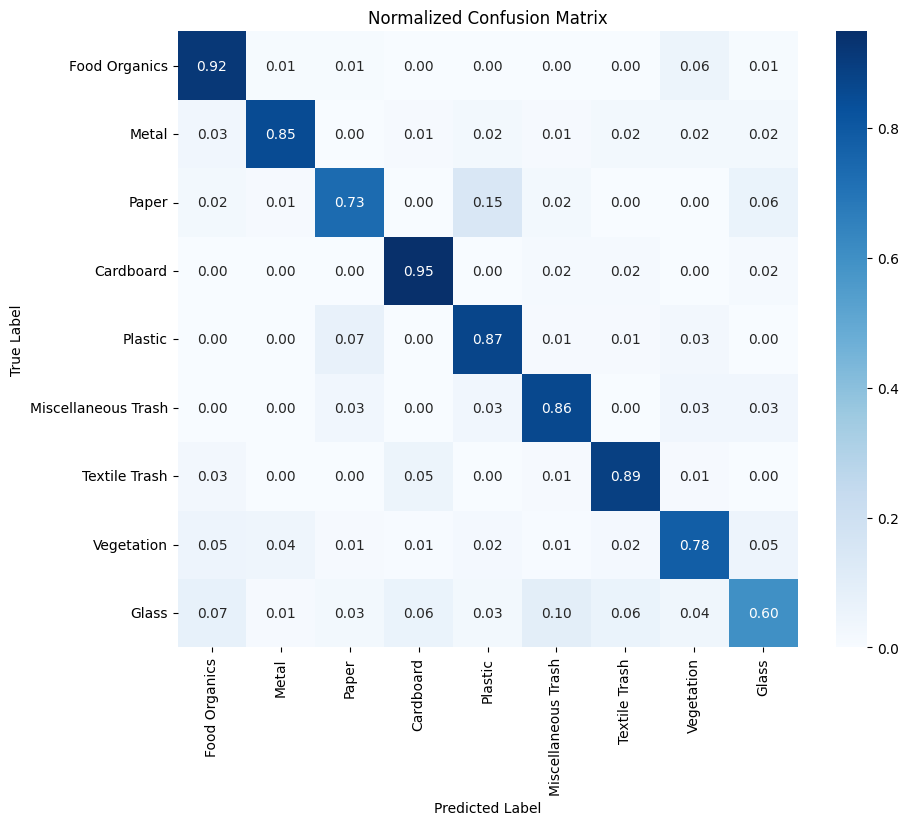

Epoch [5/5], Loss: 0.1032, Accuracy: 97.18%
Validation Loss: 0.5584, Validation Accuracy: 84.44%
Best model saved with validation accuracy: 84.44%


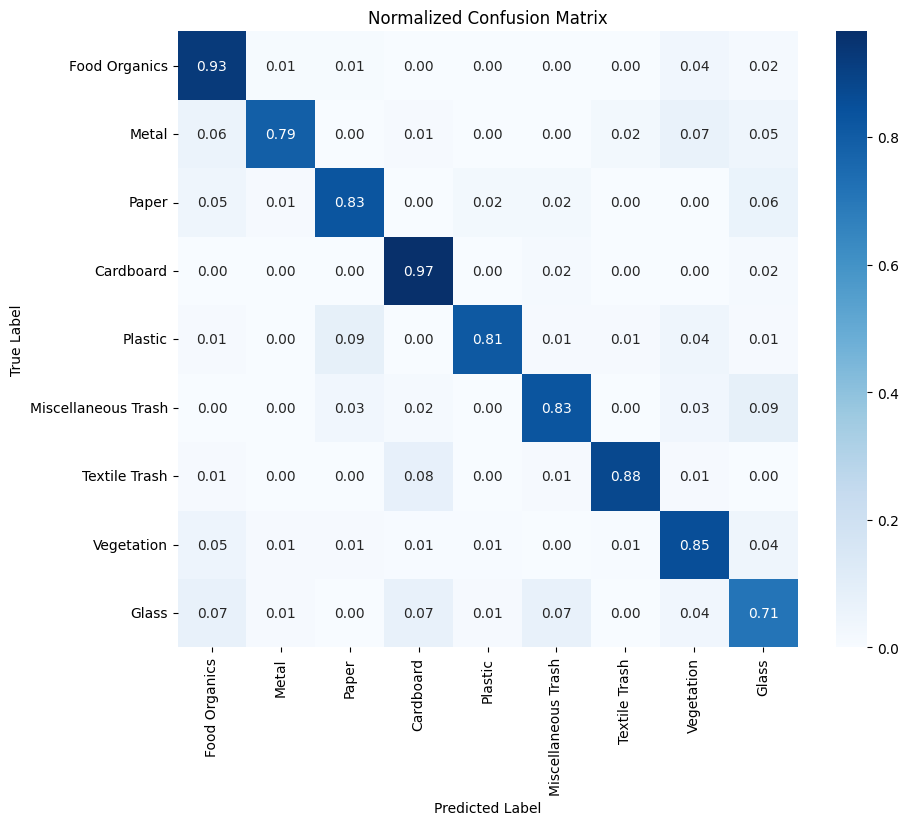

In [ ]:
fine_tuned_model = FineTunedModel(simclr_model).to(device)

# Define loss and optimizer for fine-tuning
class_weights = torch.tensor([1.0] * 9).to(device)  # Update with proper class weights if needed
criterion = lambda outputs, labels: weighted_cross_entropy_loss(outputs, labels, class_weights)
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=1e-5)

# Fine-tune the model
class_names = ['Food Organics', 'Metal', 'Paper', 'Cardboard', 'Plastic',
               'Miscellaneous Trash', 'Textile Trash', 'Vegetation', 'Glass']

fine_tune_model(train_loader, val_loader, fine_tuned_model, criterion, optimizer, epochs=5, class_names=class_names)


Test Accuracy: 82.74%


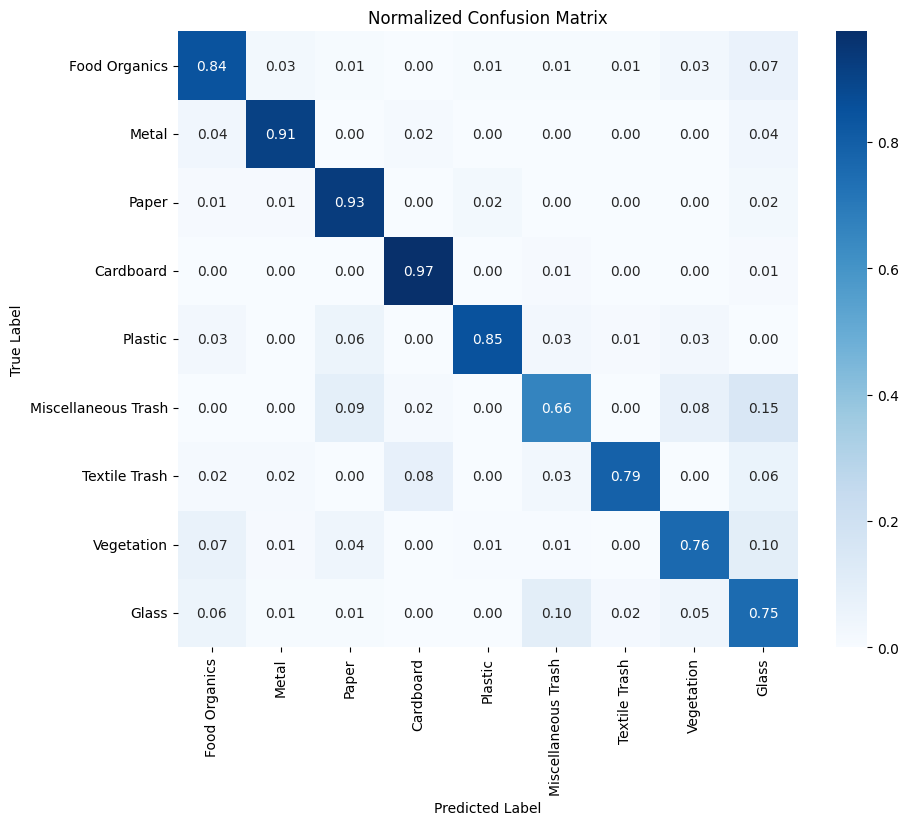

In [ ]:
# Run inference on the test set
fine_tuned_model.eval()  # Set the model to evaluation mode

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = fine_tuned_model(images)
        _, preds = torch.max(outputs, 1)

        # Store the true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy on the test set
accuracy = np.sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Optionally, compute and plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)


Custom Test Accuracy: 4.65%


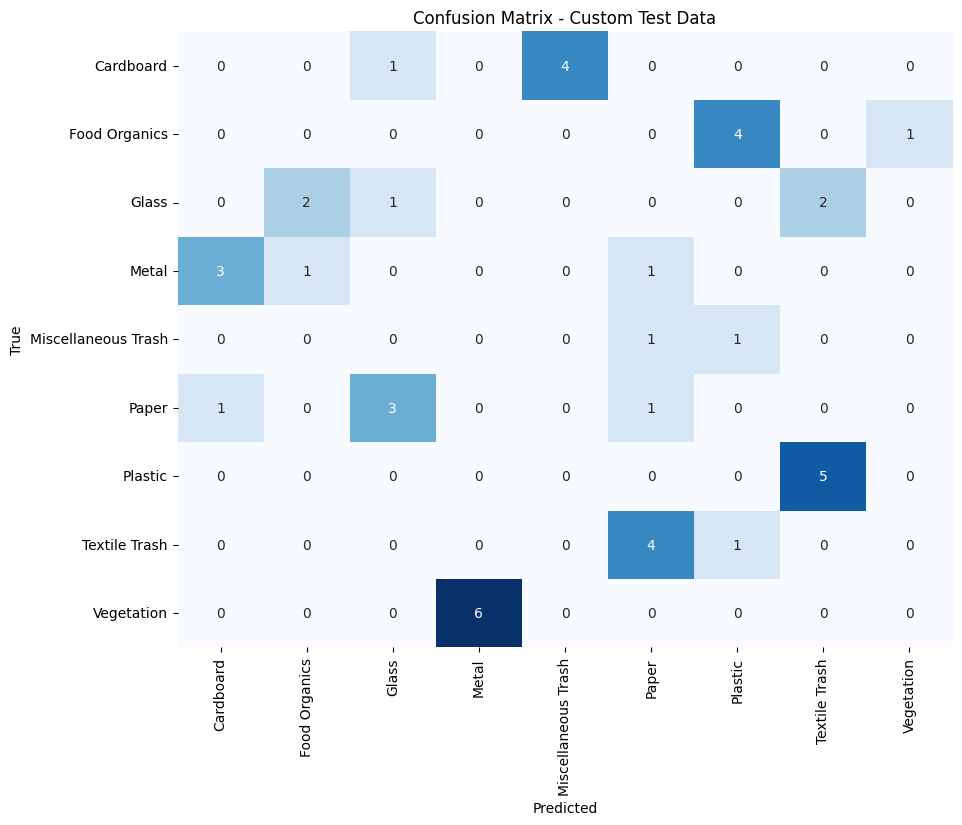

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define the same transformations used during fine-tuning ---
finetune_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# --- Load Custom Test Data ---
custom_test_dir = '/kaggle/input/last-test/test'
custom_test_dataset = datasets.ImageFolder(custom_test_dir, transform=None)  # No transformation initially

# Apply the same transformations as in fine-tuning
custom_test_dataset.transform = finetune_transforms  # Apply the same transformations used in training/validation

# Create DataLoader for custom test data
batch_size = 32  # You can adjust the batch size as needed
custom_test_loader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Run inference on custom test data ---
all_labels = []
all_preds = []

fine_tuned_model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # No gradient computation needed for inference
    for images, labels in custom_test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = fine_tuned_model(images)

        # Get predicted classes
        _, preds = torch.max(outputs, 1)

        # Store the true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# --- Calculate accuracy ---
accuracy = np.sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels) * 100
print(f"Custom Test Accuracy: {accuracy:.2f}%")

# --- Compute confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)

# --- Plot confusion matrix ---
class_names = list(custom_test_dataset.classes)  # Class names for the custom test dataset
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom Test Data")
plt.show()
